# Figures for the model

## Confusion matrix - binary task

In [ ]:
"""
2359
generate micronuclei data 976
generate nuclei data 1382

Accuracy: 91.6%, Avg loss: 0.471834

TP: 786, FP: 7, TN: 1375, FN: 190

"""

Text(50.722222222222214, 0.5, 'Actual label')

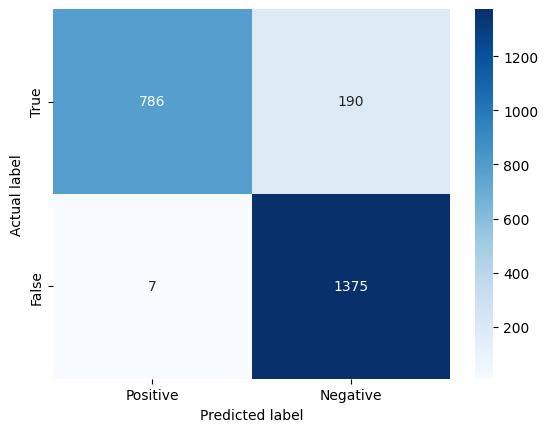

In [ ]:
import seaborn as sns
TP,FP,FN,TN = 786,7,190,1375
cm_data = [[TP, FN], [FP, TN]]
sns.heatmap(cm_data, annot=True,xticklabels=["Positive","Negative"], yticklabels=["True","False"], cmap='Blues', fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("Actual label")

##c) Comparing mcherry vs GFP – F1 score vs confidence

In [1]:
!cp /content/drive/MyDrive/PMCC/Dataset/mCherryMask_v4.zip /content/
!unzip /content/mCherryMask_v4.zip -d /content/
!cp /content/drive/MyDrive/PMCC/Dataset/mnMask_v3.zip mnMask_v3.zip
!unzip mnMask_v3.zip -d /content/

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/mnMask_v3/final_masks/GFP-H2B_A2_1_2023y07m02d_08h02m-1.npy  
  inflating: /content/mnMask_v3/final_masks/10 Gy_GFP-H2B_B1_2_2023y06m25d_11h17m_0.npy  
  inflating: /content/mnMask_v3/final_masks/GFP-H2B_A1_3_2023y07m03d_03h02m-1.npy  
  inflating: /content/mnMask_v3/final_masks/GFP-H2B_A2_1_2023y07m01d_19h02m-0.npy  
  inflating: /content/mnMask_v3/final_masks/10 Gy_GFP-H2B_B1_2_2023y06m26d_02h17m_2.npy  
  inflating: /content/mnMask_v3/final_masks/Plate 1_GFP-H2B_G20_1_2022y12m01d_23h30m-7.npy  
  inflating: /content/mnMask_v3/final_masks/10 Gy_GFP-H2B_A2_1_2023y06m24d_21h17m_0.npy  
  inflating: /content/mnMask_v3/final_masks/GFP-H2B_A3_4_2023y07m03d_08h02m-18.npy  
  inflating: /content/mnMask_v3/final_masks/GFP-H2B_A3_4_2023y07m03d_07h02m-3.npy  
  inflating: /content/mnMask_v3/final_masks/GFP-H2B_A1_1_2023y07m03d_08h02m-10.npy  
  inflating: /content/mnMask_v3/final_masks/GFP-H2B_A3_3_2023y07m02d_21h02m-19.npy  
  inflating: /conte

In [3]:
import os
import numpy as np

mask_folder = "/content/mnMask_v3/final_masks"
res = 0
img = set()
for file in os.listdir(mask_folder):
  gt_masks = np.load(os.path.join(mask_folder,file))
  res += gt_masks.shape[0]
  img.add("".join(file.split("-")[:-1]))
print("train:",len(os.listdir(mask_folder)), res)

mask_folder = "/content/mnMask_v3/test_masks"
res = 0
for file in os.listdir(mask_folder):
  gt_masks = np.load(os.path.join(mask_folder,file))
  img.add("".join(file.split("-")[:-1]))
  res += gt_masks.shape[0]
print("test:",len(os.listdir(mask_folder)), res)

mask_folder = "/content/mCherryMask_v4/red_masks"
res = 0
mimg = set()
for file in os.listdir(mask_folder):
  gt_masks = np.load(os.path.join(mask_folder,file))
  mimg.add("".join(file.split("-")[:-1]))
  res += gt_masks.shape[0]
print("mcherry:",len(os.listdir(mask_folder)), res)
print(f"the number of gfp images is {len(img)}, the number of mcherry is {len(mimg)}")

train: 1529 2967
test: 300 614
mcherry: 308 477
the number of gfp images is 687, the number of mcherry is 71


In [ ]:
# install tool
%cd /content/
!git clone https://github.com/kew6688/MicroNuclei_Detection.git
!pip install -e MicroNuclei_Detection/.
!pip show mn_segmentation
%cd /content/MicroNuclei_Detection

!cd checkpoints && \
./download_ckpts.sh

/content
Cloning into 'MicroNuclei_Detection'...
remote: Enumerating objects: 842, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 842 (delta 157), reused 129 (delta 65), pack-reused 606 (from 1)
Receiving objects: 100% (842/842), 28.53 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (513/513), done.
Obtaining file:///content/MicroNuclei_Detection
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mn_segmentation (pyproject.toml) ... done
  Created wheel for mn_segmentation: filename=mn_segmentation-0.1.0-py2.py3-none-any.whl size=5206 sha256=9d21e87af6c518afa82211be62632e7ddf06815cb1f0530171acf2cf08840be0
  Stored in directory: /tmp/pip-ephem-wheel-cache-u_tmsroy/wheels/3f/81/01/c4f05b68a1cbc02396527f710866e1b4827249f9a5d7d4b505
Successf

In [ ]:
from mn_segmentation.tests.evaluator import Evaluator
# from mn_segmentation.tests.test import evaluate_mn_dataset
from mn_segmentation.lib.Application import Application

import os
from PIL import Image
import numpy as np
from torchvision.transforms.functional import pil_to_tensor
from tqdm import tqdm
import matplotlib.pyplot as plt
import argparse
import time

def evaluate_mn_dataset(model, dataset_path, evaluator, img_folder='images', mask_folder='test_masks', mod="all", nms_iou=0.2, conf=0.4, mask_conf=0.7, ap_iou=0.5):
  for file in tqdm(os.listdir(os.path.join(dataset_path,mask_folder))[-300:]):
    # get final pred, may need customize model predict function
    im = Image.open(os.path.join(dataset_path,img_folder,file[:-4]+".png"))
    image = pil_to_tensor(im)
    pred = model._predict(image)
    pred_boxes,pred_masks,pred_scores = model._post_process(pred, conf)
    pred_boxes = pred_boxes.cpu().numpy()
    pred_masks = pred_masks.cpu().numpy()
    pred_masks = (pred_masks > mask_conf).squeeze(1)       # shape [n,w,h]
    pred_scores = pred_scores.cpu().numpy()           # shape [n]
    if pred_masks.ndim == 2:
      pred_masks = np.expand_dims(pred_masks, axis=0)
    # print(pred_masks.shape)
    # print(pred_scores.shape)

    # get GT mask
    gt_masks = np.load(os.path.join(dataset_path,mask_folder,file))  # shape [n,w,h]
    # obj_ids = np.unique(gt_masks)[1:]
    # gt_masks = (gt_masks == obj_ids[:, None, None])
    gt_masks.squeeze()
    if gt_masks.ndim == 2:
      gt_masks = np.expand_dims(gt_masks, axis=0)

    if mod=="easy" and len(gt_masks) > 3:
      continue
    if mod=="hard" and len(gt_masks) <= 3:
      continue

    # compare and update
    recall = evaluator.update(pred_masks, pred_scores, gt_masks, ap_iou)

    # uncomment this can give bad cases that cause recall drop, missing mn
    # if recall < 0.5:
    #   print(recall,file)

  evaluator.finalize()
  # evaluator.draw_pr_curve()
  return

def evaluate_mcherry_dataset(model, dataset_path, evaluator, mod="all", nms_iou=0.2, conf=0.4, mask_conf=0.7, ap_iou=0.5):
  for file in tqdm(os.listdir(os.path.join(dataset_path,'red_masks'))):
    # get final pred, may need customize model predict function
    im = Image.open(os.path.join(dataset_path,'images',file[:-4]+".png"))
    # im = im.convert("L")
    image = pil_to_tensor(im)
    pred = model._predict(image)
    pred_boxes,pred_masks,pred_scores = model._post_process(pred, conf)
    pred_boxes = pred_boxes.cpu().numpy()
    pred_masks = pred_masks.cpu().numpy()
    pred_masks = (pred_masks > mask_conf).squeeze(1)       # shape [n,w,h]
    pred_scores = pred_scores.cpu().numpy()           # shape [n]
    if pred_masks.ndim == 2:
      pred_masks = np.expand_dims(pred_masks, axis=0)
    # print(pred_masks.shape)
    # print(pred_scores.shape)

    # get GT mask
    gt_masks = np.load(os.path.join(dataset_path,'red_masks',file))  # shape [n,w,h]
    # obj_ids = np.unique(gt_masks)[1:]
    # gt_masks = (gt_masks == obj_ids[:, None, None])
    gt_masks.squeeze()
    if gt_masks.ndim == 2:
      gt_masks = np.expand_dims(gt_masks, axis=0)

    if mod=="easy" and len(gt_masks) > 3:
      continue
    if mod=="hard" and len(gt_masks) <= 3:
      continue

    # compare and update
    recall = evaluator.update(pred_masks, pred_scores, gt_masks, ap_iou)

    # uncomment this can give bad cases that cause recall drop, missing mn
    # if recall < 0.5:
    #   print(recall,file)

  evaluator.finalize()
  # evaluator.draw_pr_curve()
  return


In [ ]:
# @title app
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from mn_segmentation.lib.Application import Application
from mn_segmentation.lib.image_crop import show_crop_windows
from mn_segmentation.models.mask_rcnn import maskrcnn_mobile, maskrcnn_resnet, maskrcnn_resnet50_fpn, maskrcnn_swin

app = Application()
# model = maskrcnn_resnet50_fpn(weights=None)
# model.load_state_dict(torch.load("/content/drive/MyDrive/PMCC/checkpoints/maskrcnn-resnet50-jitter-v2-60.pt"))
# model = maskrcnn_swin()
# model.load_state_dict(torch.load("/content/drive/MyDrive/PMCC/checkpoints/maskrcnn-swin-fpn-200.pt"))
# app = Application(model=model, device=torch.device('cuda'))

In [ ]:
def draw_curve(app,path,eva,mod="all"):
  ap = []
  p = []
  f1 = []
  for i in range(10):
    print(f"============== conf: {i/10} =============")
    evaluator = NEvaluator(iou_method="Scale")
    eva(app, path, evaluator, mod=mod, conf=i/10)
    ap.append(evaluator.map)
    p.append(evaluator.precision)
    f1.append(evaluator.f1)

  plt.plot(np.arange(10)/10, ap)
  plt.plot(np.arange(10)/10, p)
  plt.plot(np.arange(10)/10, f1, linestyle="--")
  plt.legend(['AP', 'Precision', 'F1'])
  plt.xlabel('Confidence')
  plt.ylabel('Metrics')
  plt.title('Metrics vs Confidence')
  plt.show()

  return ap,p,f1

In [ ]:
# @title evaluator

import numpy as np
import math

class IoUcreator:
    def __init__(self, s):
        self.s = s

    def create(self):
        if self.s == "Standard":
            return IoU()
        if self.s == "Scale":
            return ScaleIoU()
        else:
            raise NotImplementedError

class IoU:
    def __init__(self):
        pass
    def __call__(self, pred_mask, gt_mask):
        intersection = np.logical_and(pred_mask, gt_mask).sum()
        union = np.logical_or(pred_mask, gt_mask).sum()
        iou = intersection / union
        return iou

class ScaleIoU(IoU):
    def __init__(self, gamma=0.5, kappa=64):
        self.gamma = gamma
        self.kappa = kappa

    def __call__(self, pred_mask, gt_mask):
        iou = super().__call__(pred_mask, gt_mask)

        avg_sz = (pred_mask.sum() + gt_mask.sum()) / 2
        p = 1.0 - self.gamma * math.exp(- np.sqrt(avg_sz) / self.kappa)

        return iou**p

import numpy as np
import matplotlib.pyplot as plt

def get_mask_center(mask):
    """
    Computes the center (centroid) of a binary mask.

    Parameters:
        mask (np.ndarray): 2D numpy array of the binary mask (bool or 0/1).

    Returns:
        (float, float): (row_center, col_center)
    """
    indices = np.argwhere(mask)  # Get coordinates of non-zero pixels
    if indices.size == 0:
        return None  # or raise ValueError("Mask is empty.")

    center = indices.mean(axis=0)  # Mean along rows gives centroid
    return tuple(center)

class NEvaluator:
  def __init__(self, save=False, iou_method="Standard"):
      self.pred_list = []
      self.objects = 0
      self.predictions = 0
      self.TP = 0
      self.FP = 0
      self.FN = 0
      self.precision = 0
      self.recall = 0
      self.f1 = 0
      self.map = 0

      self.save = save
      self.mn_lst = []
      self.IoU = IoUcreator(iou_method).create()

  def update(self, pred_masks, pred_scores, gt_masks, ap_iou=0.5):

    self.objects += gt_masks.shape[0]
    self.predictions += pred_masks.shape[0]

    t_cnt = 0
    for i in range(pred_masks.shape[0]):
      conf = pred_scores[i]
      res = False
      overlap = 0
      save_iou = 0
      save_gt = 0
      save_shift = 0
      for j in range(gt_masks.shape[0]):
        if gt_masks[j].sum()>1000 or gt_masks[j].sum()<5: continue
        intersection = np.logical_and(pred_masks[i], gt_masks[j]).sum()
        union = np.logical_or(pred_masks[i], gt_masks[j]).sum()
        iou = self.IoU(pred_masks[i], gt_masks[j])

        if intersection > overlap:
          overlap = intersection
          res = True if iou > ap_iou else False
          save_iou = max(save_iou, iou)
          save_gt = gt_masks[j].sum()

          gt_center = get_mask_center(gt_masks[j])
          pred_center = get_mask_center(pred_masks[i])
          save_shift = np.sqrt((gt_center[0] - pred_center[0])**2 + (gt_center[1] - pred_center[1])**2)

      if res:
        self.TP += 1
        t_cnt += 1
      else:
        self.FP += 1
      self.pred_list.append((conf, res))

      # save the positive predictions' size and iou
      if self.save and res:
        self.mn_lst.append({"pred_size":pred_masks[i].sum().item(), "label_size":save_gt.item(), "shift":save_shift.item(), "iou":save_iou.item()})

    return t_cnt/(gt_masks.shape[0]-1) if (gt_masks.shape[0]-1) > 0 else 1

  def finalize(self):
    self.FN = self.objects - self.TP
    self.pred_list.sort(key=lambda x: x[0], reverse=True)
    correct = 0
    for i in range(len(self.pred_list)):
      if self.pred_list[i][1]:
        correct += 1
      self.map += correct / (i + 1)
    self.map /= self.predictions if self.predictions != 0 else -1
    print(f"mAP: {self.map}")

    self.precision = self.TP / (self.TP + self.FP) if self.TP + self.FP != 0 else -1
    self.recall = self.TP / (self.TP + self.FN) if self.TP + self.FN != 0 else -1
    self.f1 = 2 * self.precision * self.recall / (self.precision + self.recall) if self.precision + self.recall != 0 else -1
    print(f"precision: {self.precision}")
    print(f"recall: {self.recall}")
    print(f"f1: {self.f1}")

    return self.precision, self.recall, self.f1

  def draw_pr_curve(self):
    p = []
    r = []
    correct = 0
    for i in range(len(self.pred_list)):
      if self.pred_list[i][1]:
        correct += 1
      p.append(correct / (i + 1))
      r.append(correct / self.objects)
    plt.plot(r, p)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    print(f"Average Precision: {sum(p)/len(p)}")

  def save_szIoU(self):
    return self.mn_lst

import pickle
import json
import numpy as np

def make_json_serializable(obj):
    """Recursively convert object to something JSON-serializable with pure Python types."""
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(v) for v in obj]
    elif isinstance(obj, tuple):
        return tuple(make_json_serializable(v) for v in obj)
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return make_json_serializable(obj.tolist())
    else:
        return obj

# obj = {
#     "Standard": {
#       "gfp": gfp_pred,
#       "mch": mc_pred
#     },
#     "Scale": {
#       "gfp": gfp_pred_scale,
#       "mch": mc_pred_scale
#     },
#     "GTsz": {
#       "gfp": gfp_sz,
#       "mch": mc_sz
#     }
# }

def pickle_to_json_safe(pickle_file_path, json_file_path):
    # Load the pickle file
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)

    # Convert to JSON-serializable format
    # data["Standard"]["gfp"] = make_json_serializable(data["Standard"]["gfp"])
    # data["Scale"] = make_json_serializable(data["Scale"])
    data["Standard"]["gfp"] = [{"size": x["size"].item(), "iou": x["iou"].item()} for x in data["Standard"]["gfp"]]
    data["Scale"]["gfp"] = [{"size": x["size"].item(), "iou": x["iou"].item()} for x in data["Scale"]["gfp"]]
    data["Standard"]["mch"] = [{"size": x["size"].item(), "iou": x["iou"].item()} for x in data["Standard"]["mch"]]
    data["Scale"]["mch"] = [{"size": x["size"].item(), "iou": x["iou"].item()} for x in data["Scale"]["mch"]]
    data["GTsz"]["mch"] = [x.item() for x in data["GTsz"]["mch"]]
    data["GTsz"]["gfp"] = [x.item() for x in data["GTsz"]["gfp"]]
    print(data["Scale"]["gfp"])

    # Save to JSON
    with open(json_file_path, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Successfully converted {pickle_file_path} to {json_file_path} with numpy numbers turned into int/float!")


# Example usage
# if __name__ == "__main__":
#     pickle_to_json_safe('iou.pkl', 'iou.json')

In [ ]:
# @title save predictions and Scale IoU

from functools import partial

path = "/content/mnMask_v3/"
eva = partial(evaluate_mn_dataset, img_folder="images", mask_folder="test_masks", mask_conf=0.7, ap_iou=0.1)
evaluator = NEvaluator(True)
eva(app, path, evaluator)
gfp_pred = evaluator.save_szIoU()

mc_path = "/content/mCherryMask_v4/"
eva = partial(evaluate_mn_dataset, img_folder="images", mask_folder="grey_masks", mask_conf=0.7, ap_iou=0.1)
evaluator = NEvaluator(True)
eva(app, mc_path, evaluator)
mc_pred = evaluator.save_szIoU()

100%|██████████| 300/300 [00:18<00:00, 16.38it/s]


mAP: 0.9812550329867434
precision: 0.8803418803418803
recall: 1.006514657980456
f1: 0.939209726443769


100%|██████████| 210/210 [00:10<00:00, 19.78it/s]

mAP: 0.9364063003335606
precision: 0.8126888217522659
recall: 0.8621794871794872
f1: 0.8367029548989113


In [ ]:
print(len(gfp_pred))

618


In [ ]:
gfp_sz = []
for file in os.listdir(path+"test_masks"):
  gt_masks = np.load(os.path.join(path,'test_masks',file))
  for m in gt_masks:
    gfp_sz.append(m.sum().item())
mc_sz = []
for file in os.listdir(mc_path+"grey_masks"):
  gt_masks = np.load(os.path.join(mc_path,'grey_masks',file))
  for m in gt_masks:
    mc_sz.append(m.sum().item())

In [ ]:
max(gfp_sz)

214.0

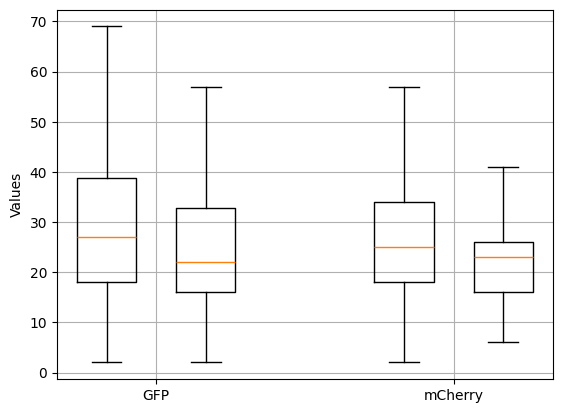

average size for GFP: 30.980582524271846
average size for mCherry: 27.24907063197026


In [ ]:
import matplotlib.pyplot as plt

# Example data
list1 = [x["pred_size"] for x in gfp_pred]
list2 = gfp_sz
list3 = [x["pred_size"] for x in mc_pred]
list4 = mc_sz

# Grouping
data = [list1, list2, list3, list4]
labels = ['Group 1 - A', 'Group 1 - B', 'Group 2 - A', 'Group 2 - B']

# Set up positions: two groups, with some space between them
positions = [1, 2, 4, 5]  # 1 & 2 close, 4 & 5 close

# Make boxplot
fig, ax = plt.subplots()
bp = ax.boxplot(data, positions=positions, widths=0.6, showfliers=False)

# Set x-axis ticks to be centered between groups
ax.set_xticks([1.5, 4.5])
ax.set_xticklabels(['GFP', 'mCherry'])

# Optional: grid and labels
ax.grid(True)
ax.set_ylabel('Values')

plt.show()

print(f"average size for GFP: {sum(list1)/len(list1)}")
print(f"average size for mCherry: {sum(list3)/len(list3)}")

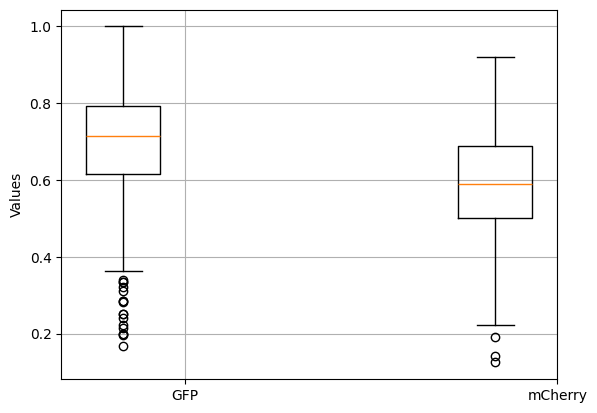

average iou for GFP: 0.6917239483615418
average iou for mCherry: 0.5844179839360464


In [ ]:
import matplotlib.pyplot as plt

# Example data
list1 = [x["iou"] for x in gfp_pred]
list2 = [x["iou"] for x in mc_pred]

# Grouping
data = [list1, list2]
labels = ['Group 1 - A', 'Group 1 - B']

# Set up positions: two groups, with some space between them
positions = [1, 4]  # 1 & 2 close, 4 & 5 close

# Make boxplot
fig, ax = plt.subplots()
bp = ax.boxplot(data, positions=positions, widths=0.6)

# Set x-axis ticks to be centered between groups
ax.set_xticks([1.5, 4.5])
ax.set_xticklabels(['GFP', 'mCherry'])

# Optional: grid and labels
ax.grid(True)
ax.set_ylabel('Values')

plt.show()

print(f"average iou for GFP: {sum(list1)/len(list1)}")
print(f"average iou for mCherry: {sum(list2)/len(list2)}")

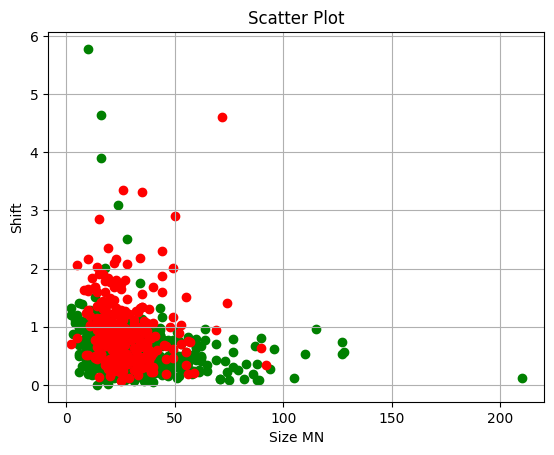

In [ ]:
import matplotlib.pyplot as plt

# Example data
x1 = [x["pred_size"] for x in gfp_pred_scale]  # x-axis values
y1 = [x["shift"] for x in gfp_pred_scale]  # y-axis values
x2 = [x["pred_size"] for x in mc_pred]  # x-axis values
y2 = [x["shift"] for x in mc_pred]  # y-axis values

# Create scatter plot
# Create scatter plot
plt.scatter(x1, y1, color='green', label='Group 1')
plt.scatter(x2, y2, color='red', label='Group 2')

# Add a horizontal line at y = 0.5
# plt.axhline(y=0.5, color='black', linestyle='--')

# Add labels
plt.xlabel('Size MN')
plt.ylabel('Shift')
plt.title('Scatter Plot')

# Show the plot
plt.grid(True)
plt.show()

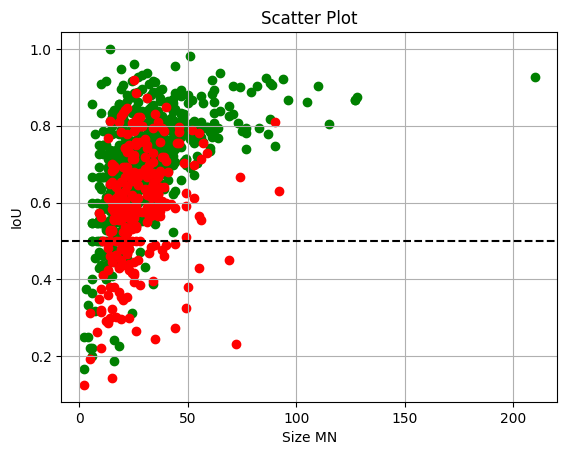

In [ ]:
from functools import partial

path = "/content/mnMask_v3/"
eva = partial(evaluate_mn_dataset, img_folder="images", mask_folder="test_masks", mask_conf=0.7, ap_iou=0.1)
evaluator = NEvaluator(True, "Scale")
eva(app, path, evaluator)
gfp_pred_scale = evaluator.save_szIoU()

mc_path = "/content/mCherryMask_v4/"
eva = partial(evaluate_mn_dataset, img_folder="images", mask_folder="grey_masks", mask_conf=0.7, ap_iou=0.1)
evaluator = NEvaluator(True, "Scale")
eva(app, mc_path, evaluator)
mc_pred_scale = evaluator.save_szIoU()

x1 = [x["pred_size"] for x in gfp_pred]  # x-axis values
y1 = [x["iou"] for x in gfp_pred]  # y-axis values
x2 = [x["pred_size"] for x in mc_pred]  # x-axis values
y2 = [x["iou"] for x in mc_pred]  # y-axis values

# Create scatter plot
# Create scatter plot
plt.scatter(x1, y1, color='green', label='Group 1')
plt.scatter(x2, y2, color='red', label='Group 2')

# Add a horizontal line at y = 0.5
plt.axhline(y=0.5, color='black', linestyle='--')

# Add labels
plt.xlabel('Size MN')
plt.ylabel('IoU')
plt.title('Scatter Plot')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
print(len(gfp_pred), len(gfp_pred_scale))

618 619


In [ ]:
obj = {
    "Standard": {
      "gfp": gfp_pred,
      "mch": mc_pred
    },
    "Scale": {
      "gfp": gfp_pred_scale,
      "mch": mc_pred_scale
    },
    "GTsz": {
      "gfp": gfp_sz,
      "mch": mc_sz
    }
}

# Define a custom encoder to handle NumPy data types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

import json
with open('/content/iou.json', 'w') as f:
  json.dump(obj, f, cls=NumpyEncoder)


In [ ]:
print(len(obj["Scale"]["gfp"]))
# obj["Scale"]["gfp"].pop(581)
# for i in range(618):
#   if obj["Scale"]["gfp"][i]['pred_size'] != obj["Standard"]["gfp"][i]['pred_size']:
#     print(i, obj["Scale"]["gfp"][i],obj["Standard"]["gfp"][i])

618


============== conf: 0.0 =============


100%|██████████| 300/300 [00:17<00:00, 16.94it/s]


mAP: 0.9281273156574841
precision: 0.7150313152400835
recall: 1.1830742659758204
f1: 0.8913467794404684
============== conf: 0.1 =============


100%|██████████| 300/300 [00:15<00:00, 19.21it/s]


mAP: 0.9570388438534683
precision: 0.7869249394673123
recall: 1.1226252158894645
f1: 0.9252669039145907
============== conf: 0.2 =============


100%|██████████| 300/300 [00:15<00:00, 19.20it/s]


mAP: 0.9756383479221363
precision: 0.8399452804377565
recall: 1.0604490500863557
f1: 0.9374045801526717
============== conf: 0.3 =============


100%|██████████| 300/300 [00:15<00:00, 19.20it/s]


mAP: 0.9835157971930041
precision: 0.8675400291120815
recall: 1.0293609671848014
f1: 0.9415481832543444
============== conf: 0.4 =============


100%|██████████| 300/300 [00:15<00:00, 19.12it/s]


mAP: 0.9872183279316056
precision: 0.8855421686746988
recall: 1.0155440414507773
f1: 0.9460981496379728
============== conf: 0.5 =============


100%|██████████| 300/300 [00:15<00:00, 19.12it/s]


mAP: 0.989420066258836
precision: 0.8967642526964561
recall: 1.005181347150259
f1: 0.9478827361563519
============== conf: 0.6 =============


100%|██████████| 300/300 [00:15<00:00, 19.10it/s]


mAP: 0.9923759815873443
precision: 0.9186602870813397
recall: 0.9948186528497409
f1: 0.955223880597015
============== conf: 0.7 =============


100%|██████████| 300/300 [00:15<00:00, 19.17it/s]


mAP: 0.9948989068056981
precision: 0.9402985074626866
recall: 0.9792746113989638
f1: 0.9593908629441624
============== conf: 0.8 =============


100%|██████████| 300/300 [00:15<00:00, 19.23it/s]


mAP: 0.9962152278480272
precision: 0.9505962521294719
recall: 0.9637305699481865
f1: 0.9571183533447684
============== conf: 0.9 =============


100%|██████████| 300/300 [00:15<00:00, 19.28it/s]


mAP: 0.9981028564713857
precision: 0.972972972972973
recall: 0.9326424870466321
f1: 0.9523809523809524


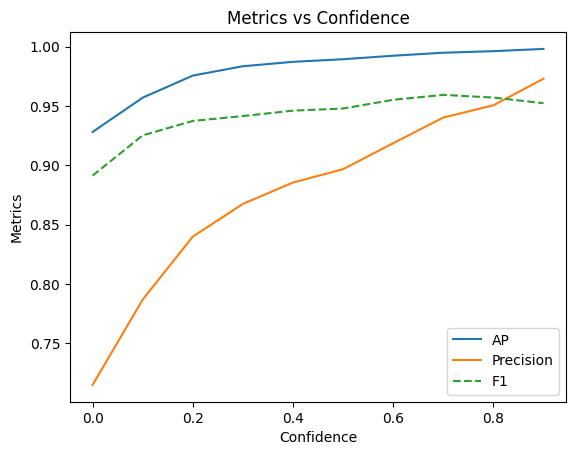

In [ ]:
# @title green mix all
from functools import partial
path = "/content/mnMask_v2/"
eva = partial(evaluate_mn_dataset, img_folder="images", mask_folder="final_masks", mask_conf=0.7, ap_iou=0.1)
ap1,p1,f11=draw_curve(app, path, eva)

============== conf: 0.0 =============


100%|██████████| 300/300 [00:15<00:00, 19.06it/s]


mAP: 0.828561952793072
precision: 0.5131578947368421
recall: 0.9341317365269461
f1: 0.6624203821656051
============== conf: 0.1 =============


100%|██████████| 300/300 [00:15<00:00, 19.16it/s]


mAP: 0.880630433358753
precision: 0.6039215686274509
recall: 0.9221556886227545
f1: 0.7298578199052133
============== conf: 0.2 =============


100%|██████████| 300/300 [00:15<00:00, 19.18it/s]


mAP: 0.9190182342195747
precision: 0.7025171624713958
recall: 0.9191616766467066
f1: 0.7963683527885863
============== conf: 0.3 =============


100%|██████████| 300/300 [00:15<00:00, 19.34it/s]


mAP: 0.9301607507492922
precision: 0.7342995169082126
recall: 0.9101796407185628
f1: 0.8128342245989305
============== conf: 0.4 =============


100%|██████████| 300/300 [00:15<00:00, 19.31it/s]


mAP: 0.9383583077570559
precision: 0.7651515151515151
recall: 0.907185628742515
f1: 0.8301369863013698
============== conf: 0.5 =============


100%|██████████| 300/300 [00:15<00:00, 19.30it/s]


mAP: 0.9438422042665364
precision: 0.7885117493472585
recall: 0.9041916167664671
f1: 0.8423988842398884
============== conf: 0.6 =============


100%|██████████| 300/300 [00:15<00:00, 19.27it/s]


mAP: 0.9477539967133186
precision: 0.806970509383378
recall: 0.9011976047904192
f1: 0.8514851485148515
============== conf: 0.7 =============


100%|██████████| 300/300 [00:15<00:00, 19.30it/s]


mAP: 0.9535866715537389
precision: 0.8291316526610645
recall: 0.8862275449101796
f1: 0.8567293777134588
============== conf: 0.8 =============


100%|██████████| 300/300 [00:15<00:00, 19.30it/s]


mAP: 0.9588476052293661
precision: 0.8504398826979472
recall: 0.8682634730538922
f1: 0.8592592592592593
============== conf: 0.9 =============


100%|██████████| 300/300 [00:15<00:00, 19.40it/s]


mAP: 0.9645428355094254
precision: 0.8847352024922118
recall: 0.8502994011976048
f1: 0.8671755725190841


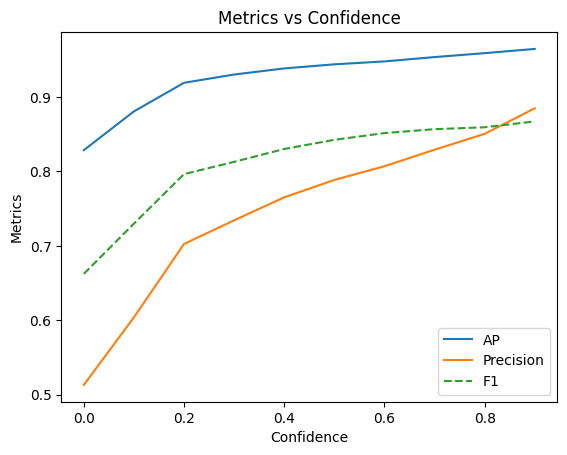

============== conf: 0.0 =============


100%|██████████| 300/300 [00:16<00:00, 18.73it/s]


mAP: 0.9228786028109195
precision: 0.6573275862068966
recall: 0.9682539682539683
f1: 0.7830551989730424
============== conf: 0.1 =============


100%|██████████| 300/300 [00:15<00:00, 18.75it/s]


mAP: 0.948870974708284
precision: 0.7314148681055156
recall: 0.9682539682539683
f1: 0.8333333333333334
============== conf: 0.2 =============


100%|██████████| 300/300 [00:15<00:00, 18.80it/s]


mAP: 0.9701471119864432
precision: 0.8198924731182796
recall: 0.9682539682539683
f1: 0.8879184861717613
============== conf: 0.3 =============


100%|██████████| 300/300 [00:15<00:00, 18.86it/s]


mAP: 0.9758872206699291
precision: 0.8515406162464986
recall: 0.9650793650793651
f1: 0.9047619047619048
============== conf: 0.4 =============


100%|██████████| 300/300 [00:15<00:00, 18.83it/s]


mAP: 0.9804474946678082
precision: 0.880466472303207
recall: 0.9587301587301588
f1: 0.9179331306990881
============== conf: 0.5 =============


100%|██████████| 300/300 [00:16<00:00, 18.68it/s]


mAP: 0.9841813408523357
precision: 0.9118541033434651
recall: 0.9523809523809523
f1: 0.9316770186335404
============== conf: 0.6 =============


100%|██████████| 300/300 [00:16<00:00, 18.63it/s]


mAP: 0.9856567372559314
precision: 0.9192546583850931
recall: 0.9396825396825397
f1: 0.9293563579277865
============== conf: 0.7 =============


100%|██████████| 300/300 [00:16<00:00, 18.50it/s]


mAP: 0.9864770645557109
precision: 0.9245283018867925
recall: 0.9333333333333333
f1: 0.9289099526066351
============== conf: 0.8 =============


100%|██████████| 300/300 [00:16<00:00, 18.43it/s]


mAP: 0.9883427148600331
precision: 0.9413680781758957
recall: 0.9174603174603174
f1: 0.9292604501607716
============== conf: 0.9 =============


100%|██████████| 300/300 [00:16<00:00, 18.59it/s]


mAP: 0.9905886522519064
precision: 0.9619377162629758
recall: 0.8825396825396825
f1: 0.9205298013245032


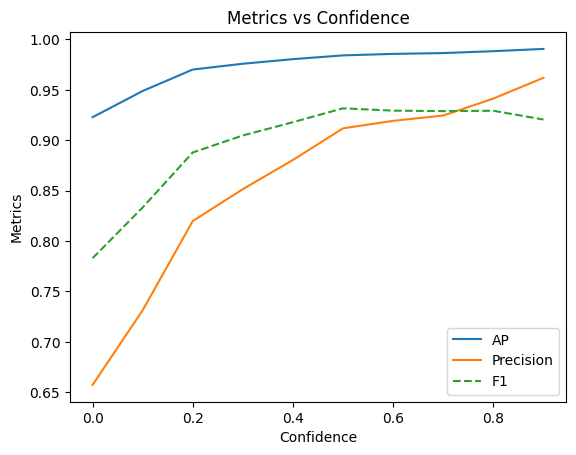

In [ ]:
# @title green mix easy vs hard
path = "/content/mnMask_v2/"
ap1,p1,f11=draw_curve(app, path, evaluate_mn_dataset,mod="easy")
ap2,p2,f12=draw_curve(app, path, evaluate_mn_dataset,mod="hard")

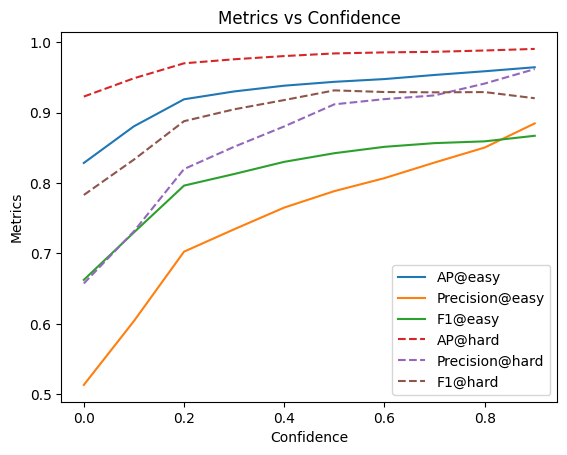

In [ ]:
plt.plot(np.arange(10)/10, ap1)
plt.plot(np.arange(10)/10, p1)
plt.plot(np.arange(10)/10, f11)
plt.plot(np.arange(10)/10, ap2, linestyle="--")
plt.plot(np.arange(10)/10, p2, linestyle="--")
plt.plot(np.arange(10)/10, f12, linestyle="--")
plt.legend(['AP@easy', 'Precision@easy', 'F1@easy','AP@hard', 'Precision@hard', 'F1@hard'])
plt.xlabel('Confidence')
plt.ylabel('Metrics')
plt.title('Metrics vs Confidence')
plt.show()

In [ ]:
# @title red mix all


============== conf: 0.0 =============


100%|██████████| 210/210 [00:10<00:00, 19.31it/s]


mAP: 0.8339132506608333
precision: 0.5830188679245283
recall: 0.9903846153846154
f1: 0.7339667458432304
============== conf: 0.1 =============


100%|██████████| 210/210 [00:10<00:00, 19.21it/s]


mAP: 0.8697792569953771
precision: 0.6585903083700441
recall: 0.9583333333333334
f1: 0.7806788511749347
============== conf: 0.2 =============


100%|██████████| 210/210 [00:10<00:00, 19.36it/s]


mAP: 0.9002276851985737
precision: 0.7084398976982097
recall: 0.8878205128205128
f1: 0.7880512091038406
============== conf: 0.3 =============


100%|██████████| 210/210 [00:10<00:00, 19.39it/s]


mAP: 0.917807773992169
precision: 0.7542372881355932
recall: 0.8557692307692307
f1: 0.8018018018018018
============== conf: 0.4 =============


100%|██████████| 210/210 [00:10<00:00, 19.44it/s]


mAP: 0.9280619521328387
precision: 0.7854984894259819
recall: 0.8333333333333334
f1: 0.8087091757387248
============== conf: 0.5 =============


100%|██████████| 210/210 [00:10<00:00, 19.56it/s]


mAP: 0.9331835546211876
precision: 0.7962382445141066
recall: 0.8141025641025641
f1: 0.8050713153724246
============== conf: 0.6 =============


100%|██████████| 210/210 [00:10<00:00, 19.61it/s]


mAP: 0.9381856793704137
precision: 0.8175895765472313
recall: 0.8044871794871795
f1: 0.8109854604200324
============== conf: 0.7 =============


100%|██████████| 210/210 [00:10<00:00, 19.54it/s]


mAP: 0.9447583872156732
precision: 0.8442906574394463
recall: 0.782051282051282
f1: 0.8119800332778702
============== conf: 0.8 =============


100%|██████████| 210/210 [00:10<00:00, 19.64it/s]


mAP: 0.9547296321450993
precision: 0.8841698841698842
recall: 0.7339743589743589
f1: 0.8021015761821366
============== conf: 0.9 =============


100%|██████████| 210/210 [00:10<00:00, 19.72it/s]


mAP: 0.9625004413494875
precision: 0.9321266968325792
recall: 0.6602564102564102
f1: 0.772983114446529


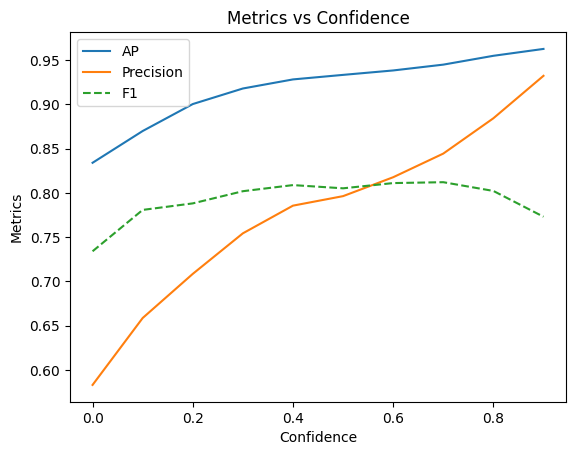

============== conf: 0.0 =============


100%|██████████| 300/300 [00:15<00:00, 19.21it/s]


mAP: 0.7990090991583872
precision: 0.5963431786216596
recall: 0.9197396963123644
f1: 0.7235494880546075
============== conf: 0.1 =============


100%|██████████| 300/300 [00:15<00:00, 19.30it/s]


mAP: 0.8318526659457484
precision: 0.6472545757071547
recall: 0.8438177874186551
f1: 0.7325800376647834
============== conf: 0.2 =============


100%|██████████| 300/300 [00:15<00:00, 19.43it/s]


mAP: 0.860720190085472
precision: 0.7033398821218074
recall: 0.7765726681127982
f1: 0.7381443298969071
============== conf: 0.3 =============


100%|██████████| 300/300 [00:15<00:00, 19.48it/s]


mAP: 0.8746163324329387
precision: 0.7386609071274298
recall: 0.7418655097613883
f1: 0.7402597402597403
============== conf: 0.4 =============


100%|██████████| 300/300 [00:15<00:00, 19.58it/s]


mAP: 0.8843742999017175
precision: 0.7622377622377622
recall: 0.7093275488069414
f1: 0.7348314606741573
============== conf: 0.5 =============


100%|██████████| 300/300 [00:15<00:00, 19.64it/s]


mAP: 0.8910845568761648
precision: 0.7684729064039408
recall: 0.6767895878524945
f1: 0.7197231833910035
============== conf: 0.6 =============


100%|██████████| 300/300 [00:15<00:00, 19.59it/s]


mAP: 0.8989792640333208
precision: 0.7941952506596306
recall: 0.6529284164859002
f1: 0.7166666666666666
============== conf: 0.7 =============


100%|██████████| 300/300 [00:15<00:00, 19.63it/s]


mAP: 0.906394592034608
precision: 0.8176638176638177
recall: 0.6225596529284165
f1: 0.706896551724138
============== conf: 0.8 =============


100%|██████████| 300/300 [00:15<00:00, 19.76it/s]


mAP: 0.914972521997303
precision: 0.8444444444444444
recall: 0.5770065075921909
f1: 0.6855670103092784
============== conf: 0.9 =============


100%|██████████| 300/300 [00:15<00:00, 19.85it/s]


mAP: 0.927443920059951
precision: 0.8803088803088803
recall: 0.4945770065075922
f1: 0.6333333333333333


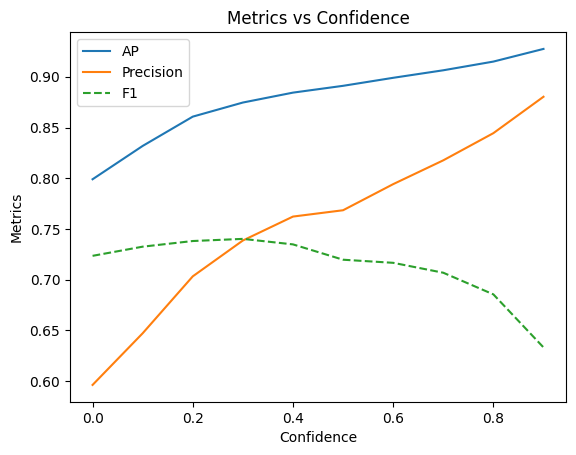

============== conf: 0.0 =============


100%|██████████| 210/210 [00:11<00:00, 19.08it/s]


mAP: 0.8316663381247033
precision: 0.5943396226415094
recall: 1.0096153846153846
f1: 0.7482185273159144
============== conf: 0.1 =============


100%|██████████| 210/210 [00:10<00:00, 19.16it/s]


mAP: 0.8658517154980513
precision: 0.6651982378854625
recall: 0.967948717948718
f1: 0.7885117493472584
============== conf: 0.2 =============


100%|██████████| 210/210 [00:10<00:00, 19.29it/s]


mAP: 0.8949383723998616
precision: 0.7161125319693095
recall: 0.8974358974358975
f1: 0.7965860597439545
============== conf: 0.3 =============


100%|██████████| 210/210 [00:10<00:00, 19.35it/s]


mAP: 0.9114570234511921
precision: 0.7570621468926554
recall: 0.8589743589743589
f1: 0.8048048048048048
============== conf: 0.4 =============


100%|██████████| 210/210 [00:10<00:00, 19.38it/s]


mAP: 0.9210854230420457
precision: 0.7854984894259819
recall: 0.8333333333333334
f1: 0.8087091757387248
============== conf: 0.5 =============


100%|██████████| 210/210 [00:10<00:00, 19.47it/s]


mAP: 0.9259445855645968
precision: 0.7962382445141066
recall: 0.8141025641025641
f1: 0.8050713153724246
============== conf: 0.6 =============


100%|██████████| 210/210 [00:10<00:00, 19.44it/s]


mAP: 0.9306637538686141
precision: 0.8175895765472313
recall: 0.8044871794871795
f1: 0.8109854604200324
============== conf: 0.7 =============


100%|██████████| 210/210 [00:10<00:00, 19.51it/s]


mAP: 0.9369427630402759
precision: 0.8408304498269896
recall: 0.7788461538461539
f1: 0.8086522462562395
============== conf: 0.8 =============


100%|██████████| 210/210 [00:10<00:00, 19.58it/s]


mAP: 0.9466900461954412
precision: 0.8764478764478765
recall: 0.7275641025641025
f1: 0.7950963222416814
============== conf: 0.9 =============


100%|██████████| 210/210 [00:10<00:00, 19.58it/s]


mAP: 0.9544103630051439
precision: 0.9276018099547512
recall: 0.657051282051282
f1: 0.7692307692307692


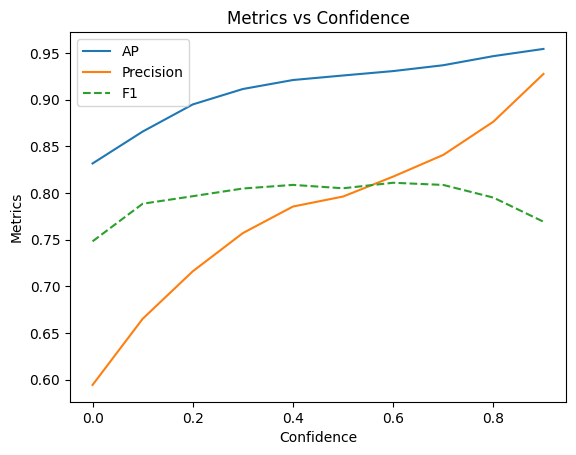

In [ ]:
from functools import partial

res_d = {}
# compare grey vs red @10
# eva = partial(evaluate_mn_dataset, img_folder="images", mask_folder="grey_masks", mask_conf=0.7, ap_iou=0.5)
# mc_path = "/content/mCherryMask_v4/"
# ap2,p2,f12=draw_curve(app, mc_path, eva)
# res_d["grey@10"] = f12

# compare grey brush vs refine @50
eva = partial(evaluate_mn_dataset, img_folder="images", mask_folder="grey_masks", mask_conf=0.7, ap_iou=0.5)
mc_path = "/content/mCherryMask_v4/"
ap2,p2,f12=draw_curve(app, mc_path, eva)
res_d["grey@50"] = f12

# eva = partial(evaluate_mn_dataset, img_folder="images", mask_folder="red_masks", mask_conf=0.7, ap_iou=0.5)
# mc_path = "/content/mCherryMask_v4/"
# ap2,p2,f12=draw_curve(app, mc_path, eva)
# res_d["red@10"] = f12

eva = partial(evaluate_mn_dataset, img_folder="images", mask_folder="red_masks", mask_conf=0.7, ap_iou=0.5)
mc_path = "/content/mCherryMask_v4/"
ap2,p2,f12=draw_curve(app, mc_path, eva)
res_d["red@50"] = f12

# eva = partial(evaluate_mn_dataset, img_folder="images", mask_folder="refined_masks", mask_conf=0.7, ap_iou=0.5)
# mc_path = "/content/mCherryMask_v4/"
# ap2,p2,f12=draw_curve(app, mc_path, eva)
# res_d["refine@10"] = f12

eva = partial(evaluate_mn_dataset, img_folder="images", mask_folder="refined_masks", mask_conf=0.7, ap_iou=0.5)
mc_path = "/content/mCherryMask_v4/"
ap2,p2,f12=draw_curve(app, mc_path, eva)
res_d["refine@50"] = f12

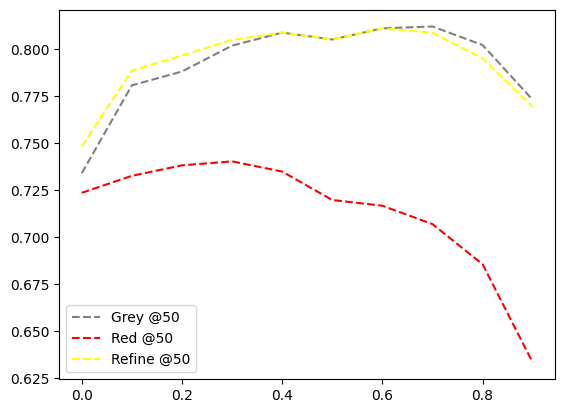

In [ ]:
import pickle
with open('/content/res_d.pkl', 'wb') as f:
  pickle.dump(res_d, f)


# Plot with labels
# plt.plot(np.arange(10)/10, res_d['grey@10'], color='grey', linestyle="-", label='Grey @10')
plt.plot(np.arange(10)/10, res_d['grey@50'], color='grey', linestyle="--", label='Grey @50')
# plt.plot(np.arange(10)/10, res_d['red@10'], color='red', linestyle="-", label='Red @10')
plt.plot(np.arange(10)/10, res_d['red@50'], color='red', linestyle="--", label='Red @50')
plt.plot(np.arange(10)/10, res_d['refine@50'], color='yellow', linestyle="--", label='Refine @50')
# plt.plot(np.arange(10)/10, res_d['refine@10'], color='yellow', linestyle="-", label='Refine @10')

# Add legend
plt.legend()

# Show plot
plt.show()

100%|██████████| 300/300 [00:00<00:00, 638.78it/s]


============== conf: 0.0 =============


100%|██████████| 300/300 [00:16<00:00, 17.80it/s]


mAP: 0.9181392622554959
precision: 0.6652314316469322
recall: 1.0766550522648084
f1: 0.8223552894211578
============== conf: 0.1 =============


100%|██████████| 300/300 [00:16<00:00, 18.06it/s]


mAP: 0.9564173659978022
precision: 0.7538071065989848
recall: 1.0348432055749128
f1: 0.8722466960352424
============== conf: 0.2 =============


100%|██████████| 300/300 [00:16<00:00, 18.21it/s]


mAP: 0.9751934199629387
precision: 0.827683615819209
recall: 1.0209059233449478
f1: 0.9141965678627144
============== conf: 0.3 =============


100%|██████████| 300/300 [00:16<00:00, 18.28it/s]


mAP: 0.9821198534899422
precision: 0.8573551263001485
recall: 1.005226480836237
f1: 0.92542101042502
============== conf: 0.4 =============


100%|██████████| 300/300 [00:16<00:00, 18.33it/s]


mAP: 0.9859719298819696
precision: 0.880184331797235
recall: 0.9982578397212544
f1: 0.9355102040816327
============== conf: 0.5 =============


100%|██████████| 300/300 [00:16<00:00, 18.38it/s]


mAP: 0.9891099542509432
precision: 0.9047619047619048
recall: 0.9930313588850174
f1: 0.946843853820598
============== conf: 0.6 =============


100%|██████████| 300/300 [00:16<00:00, 18.40it/s]


mAP: 0.9910256104695894
precision: 0.9170731707317074
recall: 0.9825783972125436
f1: 0.9486963835155593
============== conf: 0.7 =============


100%|██████████| 300/300 [00:16<00:00, 18.38it/s]


mAP: 0.9928823130957981
precision: 0.9364548494983278
recall: 0.975609756097561
f1: 0.9556313993174061
============== conf: 0.8 =============


100%|██████████| 300/300 [00:16<00:00, 18.47it/s]


mAP: 0.9947728489135277
precision: 0.9547826086956521
recall: 0.9564459930313589
f1: 0.9556135770234987
============== conf: 0.9 =============


100%|██████████| 300/300 [00:16<00:00, 18.46it/s]


mAP: 0.996640168024966
precision: 0.9722735674676525
recall: 0.9163763066202091
f1: 0.9434977578475336


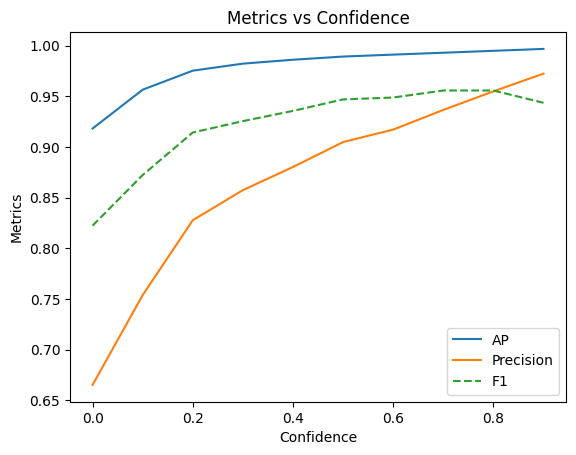

============== conf: 0.0 =============


100%|██████████| 300/300 [00:16<00:00, 17.82it/s]


mAP: 0.9011290633228729
precision: 0.6219512195121951
recall: 1.0662020905923344
f1: 0.785622593068036
============== conf: 0.1 =============


100%|██████████| 300/300 [00:16<00:00, 18.00it/s]


mAP: 0.9410549218630492
precision: 0.7161520190023754
recall: 1.0505226480836236
f1: 0.8516949152542374
============== conf: 0.2 =============


100%|██████████| 300/300 [00:16<00:00, 18.05it/s]


mAP: 0.9678777515889648
precision: 0.7989130434782609
recall: 1.024390243902439
f1: 0.8977099236641222
============== conf: 0.3 =============


100%|██████████| 300/300 [00:16<00:00, 18.17it/s]


mAP: 0.9759685631993907
precision: 0.8340486409155937
recall: 1.0156794425087108
f1: 0.9159465828750981
============== conf: 0.4 =============


100%|██████████| 300/300 [00:16<00:00, 18.25it/s]


mAP: 0.9817393279325547
precision: 0.8609865470852018
recall: 1.0034843205574913
f1: 0.926790024135157
============== conf: 0.5 =============


100%|██████████| 300/300 [00:16<00:00, 18.26it/s]


mAP: 0.9852809191625359
precision: 0.8858024691358025
recall: 1.0
f1: 0.939443535188216
============== conf: 0.6 =============


100%|██████████| 300/300 [00:16<00:00, 18.23it/s]


mAP: 0.9864835805157028
precision: 0.89375
recall: 0.9965156794425087
f1: 0.9423393739703461
============== conf: 0.7 =============


100%|██████████| 300/300 [00:16<00:00, 18.26it/s]


mAP: 0.9886750130725076
precision: 0.907051282051282
recall: 0.9860627177700348
f1: 0.9449081803005008
============== conf: 0.8 =============


100%|██████████| 300/300 [00:16<00:00, 18.26it/s]


mAP: 0.9915674256944556
precision: 0.9332220367278798
recall: 0.9738675958188153
f1: 0.9531116794543906
============== conf: 0.9 =============


100%|██████████| 300/300 [00:16<00:00, 18.42it/s]


mAP: 0.9943681567934313
precision: 0.9573712255772646
recall: 0.9390243902439024
f1: 0.9481090589270008


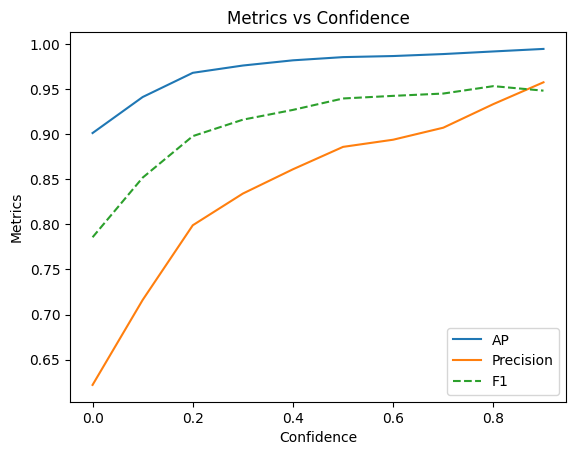

============== conf: 0.0 =============


100%|██████████| 300/300 [00:16<00:00, 17.75it/s]


mAP: 0.8898942004174766
precision: 0.6049261083743842
recall: 1.0696864111498259
f1: 0.7728130899937068
============== conf: 0.1 =============


100%|██████████| 300/300 [00:16<00:00, 17.96it/s]


mAP: 0.9347580312993263
precision: 0.6997663551401869
recall: 1.043554006968641
f1: 0.8377622377622378
============== conf: 0.2 =============


100%|██████████| 300/300 [00:16<00:00, 18.12it/s]


mAP: 0.9603503957233724
precision: 0.7684210526315789
recall: 1.0174216027874565
f1: 0.8755622188905547
============== conf: 0.3 =============


100%|██████████| 300/300 [00:16<00:00, 18.14it/s]


mAP: 0.9738592161283846
precision: 0.8236130867709816
recall: 1.0087108013937283
f1: 0.9068128425998433
============== conf: 0.4 =============


100%|██████████| 300/300 [00:16<00:00, 18.22it/s]


mAP: 0.9795846185177977
precision: 0.8474074074074074
recall: 0.9965156794425087
f1: 0.9159327461969575
============== conf: 0.5 =============


100%|██████████| 300/300 [00:16<00:00, 18.21it/s]


mAP: 0.9825730728531862
precision: 0.866464339908953
recall: 0.9947735191637631
f1: 0.9261962692619627
============== conf: 0.6 =============


100%|██████████| 300/300 [00:16<00:00, 18.21it/s]


mAP: 0.9852297797337528
precision: 0.8864696734059098
recall: 0.9930313588850174
f1: 0.9367296631059984
============== conf: 0.7 =============


100%|██████████| 300/300 [00:16<00:00, 18.32it/s]


mAP: 0.9881729146348143
precision: 0.9083601286173634
recall: 0.9843205574912892
f1: 0.9448160535117058
============== conf: 0.8 =============


100%|██████████| 300/300 [00:16<00:00, 18.27it/s]


mAP: 0.9908555825433453
precision: 0.9265442404006677
recall: 0.9668989547038328
f1: 0.9462915601023018
============== conf: 0.9 =============


100%|██████████| 300/300 [00:16<00:00, 18.33it/s]


mAP: 0.9934258468728869
precision: 0.9491228070175438
recall: 0.9425087108013938
f1: 0.9458041958041958


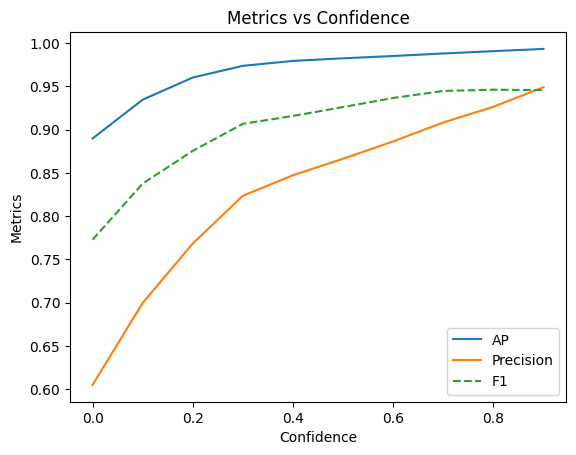

============== conf: 0.0 =============


100%|██████████| 300/300 [00:16<00:00, 17.98it/s]


mAP: 0.913729949833465
precision: 0.6447507953340403
recall: 1.0592334494773519
f1: 0.8015820698747528
============== conf: 0.1 =============


100%|██████████| 300/300 [00:16<00:00, 18.07it/s]


mAP: 0.9493864893347685
precision: 0.7291666666666666
recall: 1.0365853658536586
f1: 0.8561151079136692
============== conf: 0.2 =============


100%|██████████| 300/300 [00:16<00:00, 18.29it/s]


mAP: 0.9741139644787465
precision: 0.8240223463687151
recall: 1.0278745644599303
f1: 0.9147286821705426
============== conf: 0.3 =============


100%|██████████| 300/300 [00:16<00:00, 18.29it/s]


mAP: 0.9829485514669465
precision: 0.8686567164179104
recall: 1.0139372822299653
f1: 0.9356913183279744
============== conf: 0.4 =============


100%|██████████| 300/300 [00:16<00:00, 18.24it/s]


mAP: 0.9860190815229983
precision: 0.8863287250384024
recall: 1.005226480836237
f1: 0.9420408163265307
============== conf: 0.5 =============


100%|██████████| 300/300 [00:16<00:00, 18.32it/s]


mAP: 0.9894898076464426
precision: 0.9137380191693291
recall: 0.9965156794425087
f1: 0.9533333333333334
============== conf: 0.6 =============


100%|██████████| 300/300 [00:16<00:00, 18.32it/s]


mAP: 0.9914487767344485
precision: 0.9277504105090312
recall: 0.9843205574912892
f1: 0.9551986475063399
============== conf: 0.7 =============


100%|██████████| 300/300 [00:16<00:00, 18.37it/s]


mAP: 0.9926695724861156
precision: 0.9446308724832215
recall: 0.980836236933798
f1: 0.9623931623931624
============== conf: 0.8 =============


100%|██████████| 300/300 [00:16<00:00, 18.48it/s]


mAP: 0.993749267419564
precision: 0.9501718213058419
recall: 0.9634146341463414
f1: 0.9567474048442905
============== conf: 0.9 =============


100%|██████████| 300/300 [00:16<00:00, 18.44it/s]


mAP: 0.9957882002136682
precision: 0.9672131147540983
recall: 0.9250871080139372
f1: 0.9456812110418521


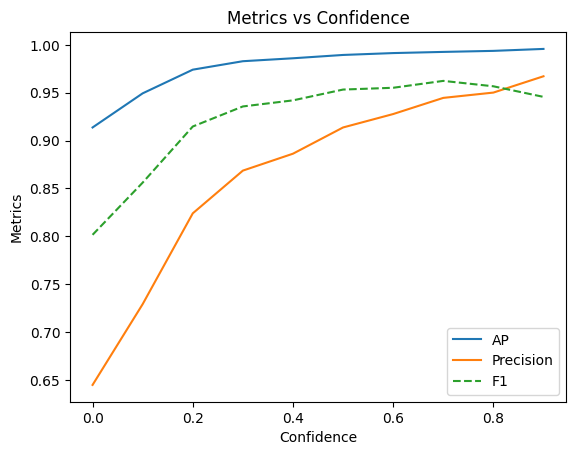

In [ ]:
import pickle

import shutil
import os
from PIL import Image
import numpy as np
from multiprocessing import Pool

def make_image(args):
    filename, source_folder, destination_folder, R, L = args
    source_mask_path = os.path.join(source_folder+"/final_masks", filename)
    destination_mask_path = os.path.join(destination_folder+"/final_masks", filename)
    source_img_path = os.path.join(source_folder+"/images", filename.replace("npy", "png"))
    destination_img_path = os.path.join(destination_folder+"/images", filename.replace("npy", "png"))

    # Copy the file
    shutil.copy2(source_mask_path, destination_mask_path)

    if L:
      image_path = source_img_path
      img = Image.open(image_path).convert("L").convert("RGB")
      img.save(destination_img_path)
      return

    image_path = source_img_path
    img = Image.open(image_path).convert("RGB").convert("HSV")
    H, S, V = img.split()

    # Choose our amount of Hue rotation
    R = R
    newH = H.point(lambda p: (p+R) % 255)

    # Recombine processed H, S and V back into a recombined image
    HSVr = Image.merge('HSV', (newH,S,V))
    # Convert recombined HSV back to reconstituted RGB, reinsert saved alpha
    RGBr = HSVr.convert('RGB')

    RGBr.save(destination_img_path)

def make_new_color_folder(source_folder="/content/mnMask_v2", destination_folder="/content/green_test", R=0, L=False):

    os.makedirs(destination_folder, exist_ok=True)
    os.makedirs(destination_folder+"/images", exist_ok=True)
    os.makedirs(destination_folder+"/final_masks", exist_ok=True)

    # Create a list of arguments for make_image
    args_list = [(x, source_folder, destination_folder, R, L) for x in (os.listdir(source_folder+"/final_masks")[-300:])]

    # Use imap to process the arguments in parallel
    with Pool(16) as p:
      list(tqdm(p.imap(make_image, args_list), total=len(args_list)))

    # for filename in tqdm(os.listdir(source_folder+"/final_masks")):

    #   source_mask_path = os.path.join(source_folder+"/final_masks", filename)
    #   destination_mask_path = os.path.join(destination_folder+"/final_masks", filename)
    #   source_img_path = os.path.join(source_folder+"/images", filename.replace("npy", "png"))
    #   destination_img_path = os.path.join(destination_folder+"/images", filename.replace("npy", "png"))

    #   # Copy the file
    #   shutil.copy2(source_mask_path, destination_mask_path)

    #   if L:
    #     image_path = source_img_path
    #     img = Image.open(image_path).convert("L").convert("RGB")
    #     img.save(destination_img_path)
    #     continue

    #   image_path = source_img_path
    #   img = Image.open(image_path).convert("RGB").convert("HSV")
    #   H, S, V = img.split()

    #   # Choose our amount of Hue rotation
    #   R = R
    #   newH = H.point(lambda p: (p+R) % 255)

    #   # Recombine processed H, S and V back into a recombined image
    #   HSVr = Image.merge('HSV', (newH,S,V))
    #   # Convert recombined HSV back to reconstituted RGB, reinsert saved alpha
    #   RGBr = HSVr.convert('RGB')

    #   RGBr.save(destination_img_path)

gfp_path = "/content/mnMask_v2"
make_new_color_folder(source_folder=gfp_path, destination_folder="/content/green_test", R=0)
make_new_color_folder(source_folder=gfp_path, destination_folder="/content/red_test", R=-90)
make_new_color_folder(source_folder=gfp_path, destination_folder="/content/blue_test", R=90)
make_new_color_folder(source_folder=gfp_path, destination_folder="/content/grey_test", L=True)

# f1_dict = {gfp_path: f11, mc_path: f12}
import pickle
from matplotlib import pyplot as plt
import numpy as np
# with open('/content/f1_dict.pkl', 'rb') as f:
#   f1_dict = pickle.load(f)

f1_dict = {}

def draw_different_colors(dest_lst):
  for dest in dest_lst:
    path = dest
    ap,p,f1 = draw_curve(app, path, evaluate_mn_dataset)
    f1_dict[path] = f1

dest_lst = ["/content/green_test/", "/content/red_test/", "/content/blue_test/", "/content/grey_test/"]
            # ,"/content/mgreen_test/", "/content/mred_test/", "/content/mblue_test/", "/content/mgrey_test/"]

draw_different_colors(dest_lst)
with open('/content/f1_dict.pkl', 'wb') as f:
  pickle.dump(f1_dict, f)

In [ ]:
gfp_path = "/content/mnMask_v2"
make_new_color_folder(source_folder=gfp_path, destination_folder="/content/green_test", R=0)
make_new_color_folder(source_folder=gfp_path, destination_folder="/content/red_test", R=-90)
make_new_color_folder(source_folder=gfp_path, destination_folder="/content/blue_test", R=90)
make_new_color_folder(source_folder=gfp_path, destination_folder="/content/grey_test", L=True)
# mc_path = "/content/mCherryMask"
# make_new_color_folder(source_folder=mc_path, destination_folder="/content/mgreen_test", R=0)
# make_new_color_folder(source_folder=mc_path, destination_folder="/content/mred_test", R=-90)
# make_new_color_folder(source_folder=mc_path, destination_folder="/content/mblue_test", R=90)
# make_new_color_folder(source_folder=mc_path, destination_folder="/content/mgrey_test", L=True)


100%|██████████| 300/300 [00:00<00:00, 539.36it/s]


In [ ]:
!rm -r /content/green_test/
!rm -r /content/red_test/
!rm -r /content/blue_test/
!rm -r /content/grey_test/
!rm -r /content/mgreen_test/
!rm -r /content/mred_test/
!rm -r /content/mblue_test/
!rm -r /content/mgrey_test/

rm: cannot remove '/content/mgreen_test/': No such file or directory
rm: cannot remove '/content/mred_test/': No such file or directory
rm: cannot remove '/content/mblue_test/': No such file or directory
rm: cannot remove '/content/mgrey_test/': No such file or directory


<ipython-input-29-4bbcec7203bd>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


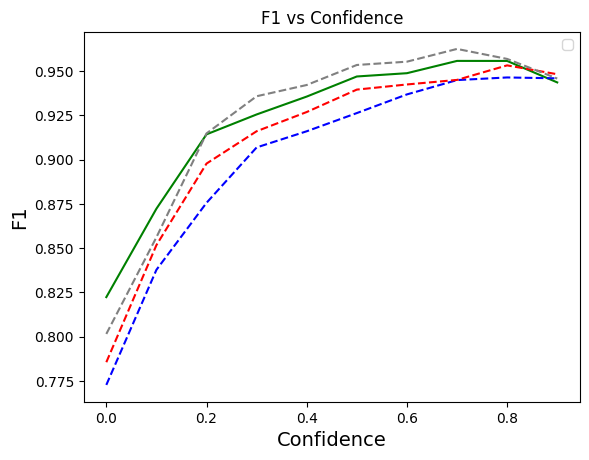

In [ ]:
import pickle
from matplotlib import pyplot as plt
import numpy as np

with open('/content/f1_dict.pkl', 'rb') as f:
  f1_dict = pickle.load(f)

# plt.plot(np.arange(10)/10, ap1)
# plt.plot(np.arange(10)/10, p1)
# plt.plot(np.arange(10)/10, f11, color='green',linestyle="-")
# plt.plot(np.arange(10)/10, ap2, linestyle="--")
# plt.plot(np.arange(10)/10, p2, linestyle="--")
# plt.plot(np.arange(10)/10, f12, color='red',linestyle="-")

plt.plot(np.arange(10)/10, f1_dict['/content/green_test/'], color='green',linestyle="-")
plt.plot(np.arange(10)/10, f1_dict['/content/blue_test/'], color='blue',linestyle="--")
plt.plot(np.arange(10)/10, f1_dict['/content/red_test/'], color='red',linestyle="--")
plt.plot(np.arange(10)/10, f1_dict['/content/grey_test/'], color='grey',linestyle="--")
# plt.plot(np.arange(10)/10, f1_dict['/content/mgreen_test/'], color='green',linestyle="--")
# plt.plot(np.arange(10)/10, f1_dict['/content/mblue_test/'], color='blue',linestyle="--")
# plt.plot(np.arange(10)/10, f1_dict['/content/mred_test/'], color='red',linestyle="-")
# plt.plot(np.arange(10)/10, f1_dict['/content/mgrey_test/'], color='grey',linestyle="--")
plt.legend()
plt.xlabel('Confidence', fontsize=14)
plt.ylabel('F1', fontsize=14)
plt.title('F1 vs Confidence')
plt.show()

<ipython-input-19-5045a42e1aa9>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


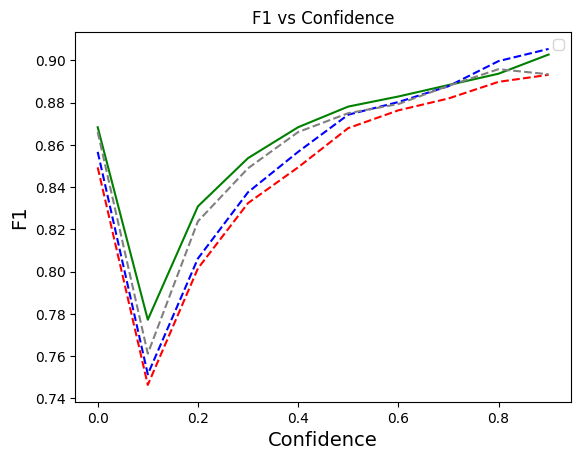

In [ ]:
# @title GFP color test
import pickle
from matplotlib import pyplot as plt
import numpy as np

with open('f1_dict.pkl', 'rb') as f:
  f1_dict = pickle.load(f)

plt.plot(np.arange(10)/10, f1_dict['/content/green_test/'], color='green',linestyle="-")
plt.plot(np.arange(10)/10, f1_dict['/content/blue_test/'], color='blue',linestyle="--")
plt.plot(np.arange(10)/10, f1_dict['/content/red_test/'], color='red',linestyle="--")
plt.plot(np.arange(10)/10, f1_dict['/content/grey_test/'], color='grey',linestyle="--")

plt.legend()
plt.xlabel('Confidence', fontsize=14)
plt.ylabel('F1', fontsize=14)
plt.title('F1 vs Confidence')
plt.show()

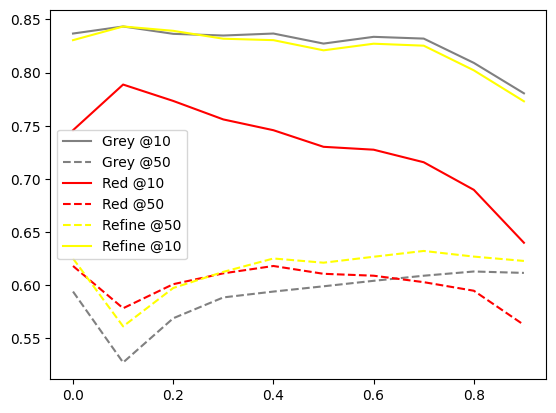

In [ ]:
# @title mCherry IoU test
import pickle
with open('res_d.pkl', 'rb') as f:
  res_d = pickle.load(f)

# Plot with labels
plt.plot(np.arange(10)/10, res_d['grey@10'], color='grey', linestyle="-", label='Grey @10')
plt.plot(np.arange(10)/10, res_d['grey@50'], color='grey', linestyle="--", label='Grey @50')
plt.plot(np.arange(10)/10, res_d['red@10'], color='red', linestyle="-", label='Red @10')
plt.plot(np.arange(10)/10, res_d['red@50'], color='red', linestyle="--", label='Red @50')
plt.plot(np.arange(10)/10, res_d['refine@50'], color='yellow', linestyle="--", label='Refine @50')
plt.plot(np.arange(10)/10, res_d['refine@10'], color='yellow', linestyle="-", label='Refine @10')

# Add legend
plt.legend()

# Show plot
plt.show()

In [ ]:
def draw_pr_curve(app,path,eva, conf):
  evaluator = Evaluator()
  eva(app, path, evaluator, conf=conf, mask_conf=0.8, ap_iou=0.5)
  evaluator.draw_pr_curve()

100%|██████████| 300/300 [00:15<00:00, 18.82it/s]


mAP: 0.970738269071785
precision: 0.88
recall: 0.9152542372881356
f1: 0.8972809667673715


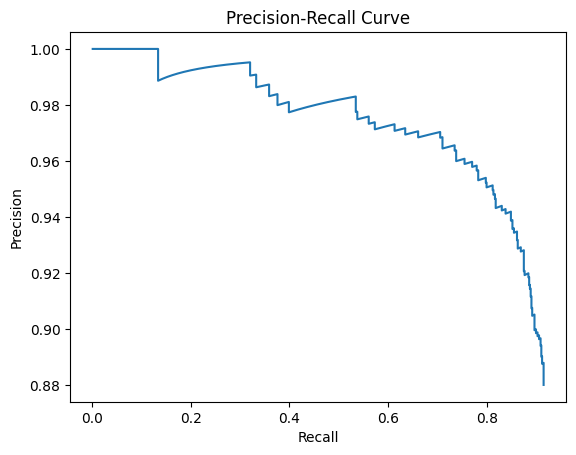

Average Precision: 0.970738269071785


In [ ]:
path = "/content/mnMask_v2/"
draw_pr_curve(app, path, evaluate_mn_dataset,0.7)

100%|██████████| 308/308 [00:15<00:00, 19.86it/s]


mAP: 0.8224161338899493
precision: 0.6795180722891566
recall: 0.5911949685534591
f1: 0.632286995515695


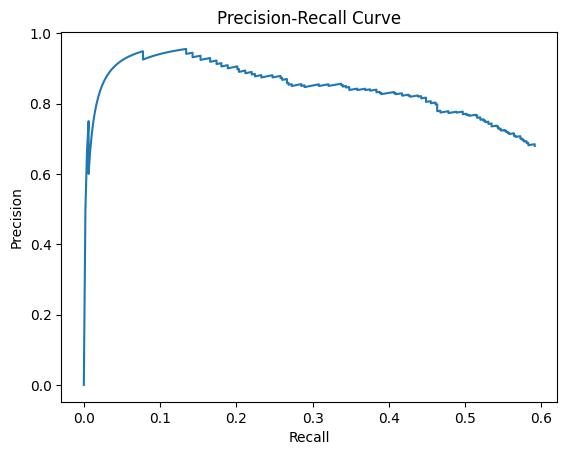

Average Precision: 0.8224161338899493


In [ ]:
path = "/content/mCherryMask/"
draw_pr_curve(app, path, evaluate_mcherry_dataset,0.5)

## benchmark

In [ ]:
import os
import shutil
for file in os.listdir("/content/drive/MyDrive/PMCC/"):
  if file.endswith(".pt"):
    # Move and rename file
    src = f'/content/drive/MyDrive/PMCC/{file}'
    dst = f'/content/drive/MyDrive/PMCC/checkpoints/{file[11:]}'

    shutil.move(src, dst)

In [ ]:
# @title different models
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from functools import partial

from mn_segmentation.lib.Application import Application
from mn_segmentation.lib.image_crop import show_crop_windows
from mn_segmentation.models.mask_rcnn import maskrcnn_mobile, maskrcnn_resnet, maskrcnn_resnet50_fpn, maskrcnn_swin

# create models
# model1 = maskrcnn_resnet50_fpn(weights="DEFAULT")
# model1.load_state_dict(torch.load("/content/drive/MyDrive/PMCC/checkpoints/maskrcnn-resnet50-v3-200.pt"))
# app = Application(model=model1, device=torch.device('cuda'))
app = Application()

model2 = maskrcnn_swin()
model2.load_state_dict(torch.load("/content/drive/MyDrive/PMCC/checkpoints/maskrcnn-swin-fpn-100.pt"))
app_swin = Application(model=model2, device=torch.device('cuda'))

model3 = maskrcnn_resnet("resnext101_32x8d", num_classes=2, pretrained=True)
model3.load_state_dict(torch.load("/content/drive/MyDrive/PMCC/checkpoints/maskrcnn-resnext101-v3-100.pt"))
app_resnext = Application(model=model3, device=torch.device('cuda'))

model = maskrcnn_resnet50_fpn(weights=None, c_anchor=True, c_rpn_nms=0.7, c_box_nms=0.5)
model.load_state_dict(torch.load("/content/drive/MyDrive/PMCC/checkpoints/maskrcnn-resnet50-fpn-anchor-ablation-200.pt"))
app_resnet_anchor = Application(model=model, device=torch.device('cuda'))

model = maskrcnn_resnet50_fpn(weights=None, c_anchor=False, c_rpn_nms=0.7, c_box_nms=0.5)
model.load_state_dict(torch.load("/content/drive/MyDrive/PMCC/checkpoints/maskrcnn-resnet50-fpn-empty-200.pt"))
app_resnet_empty = Application(model=model, device=torch.device('cuda'))

model = maskrcnn_resnet50_fpn(weights=None, c_anchor=False, c_rpn_nms=0.7, c_box_nms=0.5,
                  rpn_fg_iou_thresh=0.5,
                  rpn_bg_iou_thresh=0.5)
model.load_state_dict(torch.load("/content/drive/MyDrive/PMCC/checkpoints/maskrcnn-resnet50-fpn-nms-ablation-200.pt"))
app_resnet_nms = Application(model=model, device=torch.device('cuda'))

# evaluate
iou_method = "Scale"  # "Standard"
path = "/content/mnMask_v3/"

print("==================== maskrcnn 50  ====================")
evaluator = NEvaluator(iou_method=iou_method)
evaluate_mn_dataset(app, path, evaluator=evaluator, img_folder="images", mask_folder="test_masks", conf=0.7, mask_conf=0.7, ap_iou=0.5)
print("=============================================================")

print("==================== maskrcnn swin  ====================")
evaluator = NEvaluator(iou_method=iou_method)
evaluate_mn_dataset(app_swin, path, evaluator=evaluator, img_folder="images", mask_folder="test_masks", conf=0.7, mask_conf=0.7, ap_iou=0.5)
print("=============================================================")

print("==================== maskrcnn 101  ====================")
evaluator = NEvaluator(iou_method=iou_method)
evaluate_mn_dataset(app_resnext, path, evaluator=evaluator, img_folder="images", mask_folder="test_masks", conf=0.7, mask_conf=0.7, ap_iou=0.5)
print("=============================================================")

print("==================== maskrcnn anchor  ====================")
evaluator = NEvaluator(iou_method=iou_method)
evaluate_mn_dataset(app_resnet_anchor, path, evaluator=evaluator, img_folder="images", mask_folder="test_masks", conf=0.7, mask_conf=0.5, ap_iou=0.5)
print("=============================================================")

print("==================== maskrcnn empty  ====================")
evaluator = NEvaluator(iou_method=iou_method)
evaluate_mn_dataset(app_resnet_empty, path, evaluator=evaluator, img_folder="images", mask_folder="test_masks", conf=0.7, mask_conf=0.5, ap_iou=0.5)
print("=============================================================")

print("==================== maskrcnn nms  ====================")
evaluator = NEvaluator(iou_method=iou_method)
evaluate_mn_dataset(app_resnet_nms, path, evaluator=evaluator, img_folder="images", mask_folder="test_masks", conf=0.7, mask_conf=0.5, ap_iou=0.5)
print("=============================================================")

Using maskrcnn with swin backbone...
[128, 256, 512, 1024]
Using maskrcnn with resnext101_32x8d backbone...
==================== maskrcnn 50  ====================


100%|██████████| 300/300 [00:18<00:00, 16.15it/s]


mAP: 0.987617115841062
precision: 0.9177018633540373
recall: 0.9625407166123778
f1: 0.9395866454689984
==================== maskrcnn swin  ====================


100%|██████████| 300/300 [00:16<00:00, 18.54it/s]


mAP: 0.9810699650078091
precision: 0.9150227617602428
recall: 0.9820846905537459
f1: 0.9473684210526316
==================== maskrcnn 101  ====================


100%|██████████| 300/300 [00:22<00:00, 13.10it/s]


mAP: 0.9359416500967992
precision: 0.842756183745583
recall: 0.7768729641693811
f1: 0.8084745762711866
==================== maskrcnn anchor  ====================


100%|██████████| 300/300 [00:16<00:00, 18.35it/s]


mAP: 0.9217373383360833
precision: 0.8517298187808896
recall: 0.8420195439739414
f1: 0.8468468468468469
==================== maskrcnn empty  ====================


100%|██████████| 300/300 [00:16<00:00, 17.68it/s]


mAP: 0.9158672901249982
precision: 0.8422818791946308
recall: 0.8175895765472313
f1: 0.8297520661157025
==================== maskrcnn nms  ====================


100%|██████████| 300/300 [00:16<00:00, 17.80it/s]

mAP: 0.9484822951387396
precision: 0.8841911764705882
recall: 0.7833876221498371
f1: 0.8307426597582038


In [ ]:
from mn_segmentation.models.mask_rcnn import maskrcnn_mobile, maskrcnn_resnet, maskrcnn_resnet50_fpn, maskrcnn_swin

model3 = maskrcnn_resnet("resnext101_32x8d", num_classes=2, pretrained=True)
model3.load_state_dict(torch.load("/content/drive/MyDrive/PMCC/checkpoints/maskrcnn-resnext101-v3-170.pt"))
app_resnext = Application(model=model3, device=torch.device('cuda'))

print("==================== maskrcnn 101  ====================")
iou_method = "Scale"
path = "/content/mnMask_v3/"
evaluator = NEvaluator(iou_method=iou_method)
evaluate_mn_dataset(app_resnext, path, evaluator=evaluator, img_folder="images", mask_folder="test_masks", conf=0.7, mask_conf=0.7, ap_iou=0.5)
print("=============================================================")

Using maskrcnn with resnext101_32x8d backbone...
==================== maskrcnn 101  ====================


100%|██████████| 300/300 [00:23<00:00, 12.85it/s]

mAP: 0.9445222069877585
precision: 0.8672199170124482
recall: 0.6807817589576547
f1: 0.7627737226277372


### plot

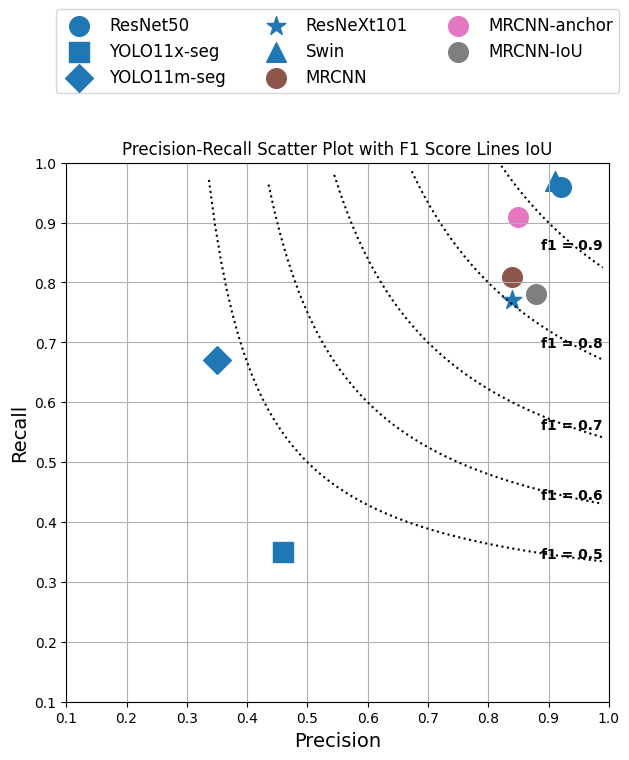

In [ ]:
# @title siou

import numpy as np
import matplotlib.pyplot as plt

def plot_models(models):
  # Extract precision and recall values
  precisions = [m[1] for m in models]
  recalls = [m[2] for m in models]
  labels = [m[0] for m in models]

  markers = ['o', 's', 'D', '*', '^', 'p', 'h', '<', '>']
  colors = plt.cm.tab10.colors

  # Create the plot
  plt.figure(figsize=(7, 7))


  scatters = []
  # first five are models results
  for i in range(5):
      scatter = plt.scatter(precisions[i], recalls[i], color=colors[0], label=labels[i], marker=markers[i], s=200)
      scatters.append(scatter)

  # last three are ablation results
  for i in range(5,8):
      scatter = plt.scatter(precisions[i], recalls[i], color=colors[i], label=labels[i], marker=markers[0], s=200)
      scatters.append(scatter)

  plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3)

  # Function to plot F1-score lines
  def plot_f1_score_line(f1_score, color='black', linestyle='dotted'):
      p_values = np.linspace(0.01, 0.99, 100)  # Precision values
      r_values = (f1_score * p_values) / (2 * p_values - f1_score)  # Compute recall values
      r_values[r_values > 1] = np.nan  # Mask invalid recall values
      plt.plot(p_values, r_values, linestyle=linestyle, color=color, label=f'F1 = {f1_score}')
      plt.text(0.99, (f1_score * 0.95) / (2 * 0.95 - f1_score), f"f1 = {f1_score}", fontsize=10, fontweight='bold', ha='right')

  # Plot F1 background lines
  plot_f1_score_line(0.9)
  plot_f1_score_line(0.8)
  plot_f1_score_line(0.7)
  plot_f1_score_line(0.6)
  plot_f1_score_line(0.5)

# Example model data (model name, precision, recall)
models = [
    ("ResNet50", 0.92, 0.96),
    ("ResNeXt101", 0.84, 0.77),
    ("Swin", 0.91, 0.97),

    ("MRCNN",0.84,0.81),
    ("MRCNN-anchor",0.85,0.91),
    ("MRCNN-IoU",0.88,0.78)
]

plot_models(models)

# Labels and title
plt.xlabel("Precision", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.title("Precision-Recall Scatter Plot with F1 Score Lines IoU")
plt.xlim(0.1, 1)
plt.ylim(0.1, 1)
plt.grid(True)

# Show plot
plt.show()


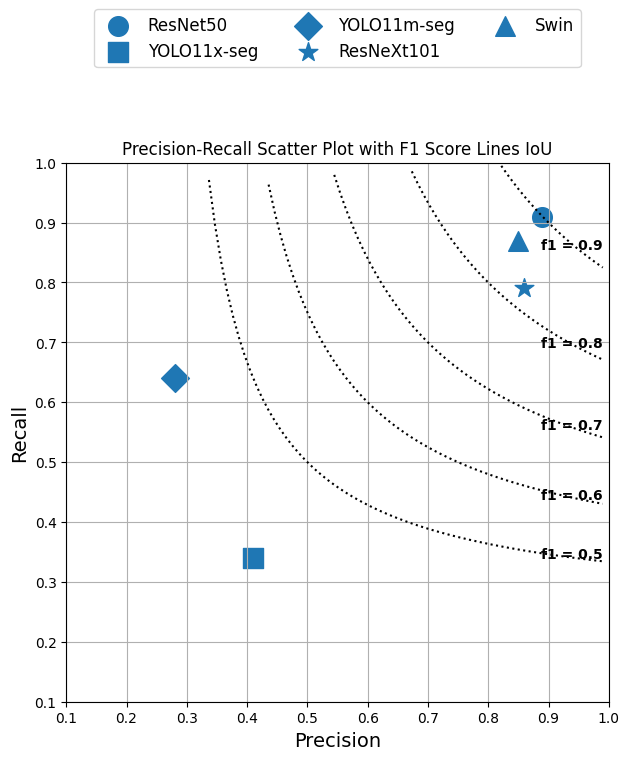

In [ ]:
# @title iou

import numpy as np
import matplotlib.pyplot as plt

def plot_models(models):
  # Extract precision and recall values
  precisions = [m[1] for m in models]
  recalls = [m[2] for m in models]
  labels = [m[0] for m in models]

  markers = ['o', 's', 'D', '*', '^', 'p', 'h', '<', '>']
  colors = plt.cm.tab10.colors

  # Create the plot
  plt.figure(figsize=(7, 7))


  scatters = []
  # first five are models results
  for i in range(5):
      scatter = plt.scatter(precisions[i], recalls[i], color=colors[0], label=labels[i], marker=markers[i], s=200)
      scatters.append(scatter)

  # last three are ablation results
  # for i in range(5,8):
  #     scatter = plt.scatter(precisions[i], recalls[i], color=colors[i], label=labels[i], marker=markers[0], s=200)
  #     scatters.append(scatter)

  plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3)

  # Function to plot F1-score lines
  def plot_f1_score_line(f1_score, color='black', linestyle='dotted'):
      p_values = np.linspace(0.01, 0.99, 100)  # Precision values
      r_values = (f1_score * p_values) / (2 * p_values - f1_score)  # Compute recall values
      r_values[r_values > 1] = np.nan  # Mask invalid recall values
      plt.plot(p_values, r_values, linestyle=linestyle, color=color, label=f'F1 = {f1_score}')
      plt.text(0.99, (f1_score * 0.95) / (2 * 0.95 - f1_score), f"f1 = {f1_score}", fontsize=10, fontweight='bold', ha='right')

  # Plot F1 background lines
  plot_f1_score_line(0.9)
  plot_f1_score_line(0.8)
  plot_f1_score_line(0.7)
  plot_f1_score_line(0.6)
  plot_f1_score_line(0.5)

# Example model data (model name, precision, recall)
models = [
    ("ResNet50", 0.89, 0.91),
    ("YOLO11x-seg", 0.41, 0.34),
    ("YOLO11m-seg", 0.28, 0.64),
    ("ResNeXt101", 0.86, 0.79),
    ("Swin", 0.85, 0.87),

    # ("MRCNN",0.67,0.80),
    # ("MRCNN-anchor",0.75,0.91),
    # ("MRCNN-IoU",0.70,0.82)
]

plot_models(models)

# Labels and title
plt.xlabel("Precision", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.title("Precision-Recall Scatter Plot with F1 Score Lines IoU")
plt.xlim(0.1, 1)
plt.ylim(0.1, 1)
plt.grid(True)

# Show plot
plt.show()


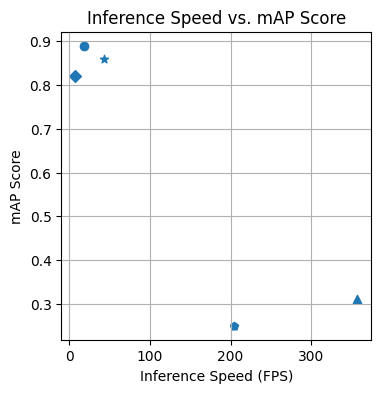

In [ ]:
# @title inference speed

import matplotlib.pyplot as plt

# Example model data (model name, inference speed in FPS, mAP score)
models = [
    ("ResNet50", 18.2, 0.89),  # 30 FPS, 85% mAP
    ("ResNeXt101", 7.6, 0.82),  # 45 FPS, 78% mAP
    ("Swin", 43.5, 0.86),  # 20 FPS, 92% mAP
    ("Yolo11m", 357, 0.31),  # 20 FPS, 92% mAP
    ("Yolo11m", 204, 0.25),  # 20 FPS, 92% mAP
]

# Extract inference speed and mAP values
inference_speeds = [m[1] for m in models]
map_scores = [m[2] for m in models]
colors = plt.cm.tab10.colors
labels = [m[0] for m in models]
markers = ['o', 'D', '*', '^', 'p', 'h', '<', '>']

# Create the plot
plt.figure(figsize=(4, 4))
# plt.scatter(inference_speeds, map_scores, color='green', label="Models")
scatters = []
for i in range(len(map_scores)):
    scatter = plt.scatter(inference_speeds[i], map_scores[i], marker=markers[i], color=colors[0], label=labels[i])
    scatters.append(scatter)
# plt.legend(handles=scatters, loc="best")

# Annotate each point with the model name
# for model, speed, map_score in models:
#     plt.text(speed, map_score, model, fontsize=8, ha='left')

# Labels and title
plt.xlabel("Inference Speed (FPS)")
plt.ylabel("mAP Score")
plt.title("Inference Speed vs. mAP Score")
# plt.xlim(0, max(inference_speeds) + 10)  # Add some space on the right
# plt.ylim(0.6, 1)  # mAP ranges from 0 to 1
plt.grid(True)

# Show plot
plt.show()


In [ ]:
resnet50: 45M
swin: 35.03G 1.379s 1.284s 1.237s

In [ ]:
60/7.9

7.594936708860759

In [ ]:
# @title overlap iou example
from mn_segmentation.tests.evaluator import Evaluator
from mn_segmentation.tests.test import evaluate_mn_dataset
from mn_segmentation.lib.Application import Application
from mn_segmentation.models.mask_rcnn import maskrcnn_mobile, maskrcnn_resnet, maskrcnn_resnet50_fpn
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

import os
from PIL import Image
import numpy as np
from torchvision.transforms.functional import pil_to_tensor
from tqdm import tqdm
import matplotlib.pyplot as plt
import argparse
import time
import torch

def calculate_iou(mask1, mask2):
    # Ensure masks are binary (0 or 1)
    mask1 = (mask1 > 0).astype(bool)
    mask2 = (mask2 > 0).astype(bool)

    # Calculate intersection and union
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    if union == 0:
        return 0.0  # Avoid division by zero

    iou = intersection / union
    # miou = my_iou(mask1, mask2)
    # if iou != miou:
    #   raise()
    return iou

def calculate_siou(mask1, mask2):
    # Ensure masks are binary (0 or 1)
    mask1 = (mask1 > 0).astype(bool)
    mask2 = (mask2 > 0).astype(bool)

    # Calculate intersection and union
    avg_sz = (mask1.sum() + mask2.sum()) / 2
    p = 1.0 - 0.5 * math.exp(- np.sqrt(avg_sz) / 64)

    iou = calculate_iou(mask1, mask2)
    return iou**p


folder = "/content/mCherryMask_v4"
file = sorted(os.listdir(os.path.join(folder,"grey_masks")))[40]
app = Application(device=torch.device('cuda'))

im = Image.open(os.path.join(folder,'images',file[:-4]+".png"))
image = pil_to_tensor(im)
pred = app._predict(image)
pred_boxes,pred_masks,pred_scores = app._post_process(pred, 0.7)
# pred_boxes = pred_boxes.cpu().numpy()
pred_masks = pred_masks.cpu()
pred_scores = pred_scores.cpu().numpy()

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"mn: {score:.3f}" for score in pred_scores]
pred_boxes = pred_boxes.long()
# output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred_masks > 0.7).squeeze(1)
output_image = draw_segmentation_masks(image, masks, alpha=0.2, colors="blue")
print(pred_labels, masks.sum())
red_masks = np.load(os.path.join(folder,'red_masks',file))
grey_masks = np.load(os.path.join(folder,'grey_masks',file))

evaluator = Evaluator()
recall = evaluator.update(masks, pred_scores, grey_masks, 0.5)
print(f"objects: {evaluator.objects}, predictions: {evaluator.predictions}")
print(f"TP: {evaluator.TP}, FP: {evaluator.FP}, FN: {evaluator.objects - evaluator.TP}")
y_indices, x_indices = np.where(masks[0] > 0)
print( y_indices.min(), y_indices.max(), x_indices.min(), x_indices.max())

['mn: 0.933'] tensor(17)
objects: 1, predictions: 1
TP: 0, FP: 1, FN: 1
167 171 127 130


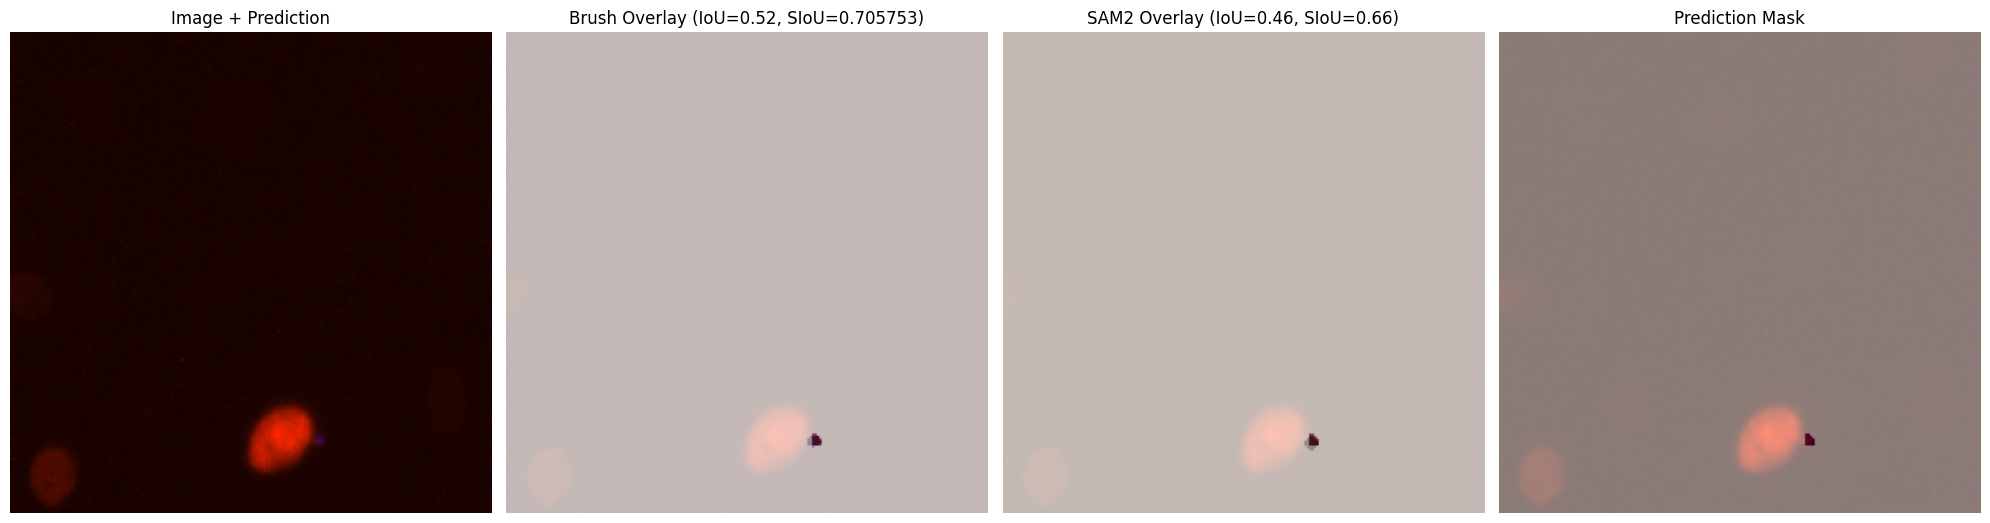

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and arrange subplots in a single row
fig, axes = plt.subplots(1, 4, figsize=(20, 10))

mn_wnd = 0, 0  # Window start (y, x)
sz = 200            # Size of crop
pre_i, gtr_i, gtg_i = 0, 0, 0  # Indices

# Extract cropped image
crop_img = output_image.permute(1, 2, 0)[mn_wnd[0]:mn_wnd[0]+sz, mn_wnd[1]:mn_wnd[1]+sz].numpy()

# --- Plot 1: Original image only ---
axes[0].imshow(crop_img)
axes[0].set_title('Image + Prediction')

# --- Plot 2: Original image with model prediction overlay ---
axes[3].imshow(crop_img)
axes[3].imshow(masks[pre_i][mn_wnd[0]:mn_wnd[0]+sz, mn_wnd[1]:mn_wnd[1]+sz], alpha=0.5, cmap='Reds')
axes[3].set_title('Prediction Mask')

# --- Plot 3: SAM2 mask overlay on image ---
sam2_mask = grey_masks[gtr_i].squeeze()[mn_wnd[0]:mn_wnd[0]+sz, mn_wnd[1]:mn_wnd[1]+sz]
axes[2].imshow(crop_img)
axes[2].imshow(sam2_mask, alpha=0.5, cmap='Greens')
axes[2].imshow(masks[pre_i][mn_wnd[0]:mn_wnd[0]+sz, mn_wnd[1]:mn_wnd[1]+sz], cmap='Reds', alpha=0.5)
iou_sam2 = calculate_iou(masks[pre_i].numpy(), grey_masks[gtr_i])
siou_sam2 = calculate_siou(masks[pre_i].numpy(), grey_masks[gtr_i])
axes[2].set_title(f'SAM2 Overlay (IoU={iou_sam2:.2f}, SIoU={siou_sam2:.2f})')

# --- Plot 4: Brush mask overlay on image ---
brush_mask = red_masks[gtg_i].squeeze()[mn_wnd[0]:mn_wnd[0]+sz, mn_wnd[1]:mn_wnd[1]+sz]
axes[1].imshow(crop_img)
axes[1].imshow(brush_mask, alpha=0.5, cmap='Blues')
axes[1].imshow(masks[pre_i][mn_wnd[0]:mn_wnd[0]+sz, mn_wnd[1]:mn_wnd[1]+sz], alpha=0.5, cmap='Reds')
iou_brush = calculate_iou(masks[pre_i].numpy(), red_masks[gtg_i])
siou_brush = calculate_siou(masks[pre_i].numpy(), red_masks[gtg_i])
axes[1].set_title(f'Brush Overlay (IoU={iou_brush:.2f}, SIoU={siou_brush:2f})')

# Clean up axis ticks
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

# nuc

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

!mkdir -p images
!wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/groceries.jpg

%cd /content/
!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-anyib_gp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-anyib_gp
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cache

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = False):

    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.3])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask = mask.squeeze()
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        if ann['area'] < 50 or ann['area'] > 1500: continue
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)


using device: cuda


In [ ]:
from torchvision.ops import masks_to_boxes
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

mask_path = "/content/mnMask_v2/brush_masks/"
imgd_path = "/content/mnMask_v2/images/"
refined_path = "/content/mnMask_v2/refined_masks/"

i = 0
for file in os.listdir(mask_path):
  img_path = os.path.join(imgd_path,file.split('.')[0]+'.png')
  print(img_path)
  refine_mask_path = os.path.join(refined_path,file)
  refine_masks = np.load(refine_mask_path)

  image = Image.open(img_path)
  image = np.array(image.convert("RGB"))

  label_mask_path = os.path.join(mask_path+file)
  label_path = np.load(label_mask_path)

  # Create a figure and arrange subplots in a single row
  fig, axes = plt.subplots(1, 3, figsize=(20, 10))

  # Plotting on each subplot
  axes[0].imshow(image)
  for mask in refine_masks:
      show_mask(mask, axes[0], random_color=False, borders=False)
  axes[0].set_title('Original Mask')

  # plot brush label
  axes[1].imshow(image)
  show_mask(label_path>0, axes[1], random_color=False)
  axes[1].set_title('Refined Mask')

  # plot compare
  axes[2].imshow(image)
  for mask in refine_masks:
      show_mask(mask, axes[2], random_color=False, borders=True)
  show_mask(label_path>0, axes[2], random_color=False)
  axes[2].set_title('Refined Mask')

  plt.axis('off')
  plt.title(f'image {i}')
  i += 1
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

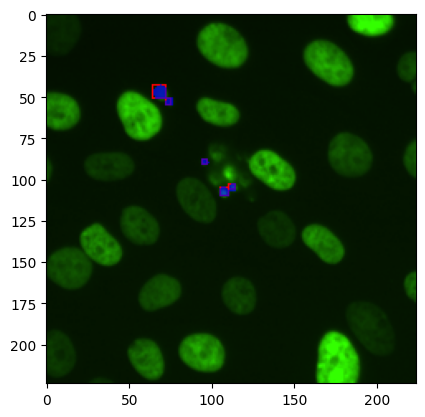

In [ ]:
image_path = "/content/mnMask_v2/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_02h57m-13.png"
point = [0,0]
output_image = app.predict_display(image_path,point,print_labels=False)
image = output_image.permute(1,2,0)
# plt.imshow(image)
plt.imsave("mn.png", image)
plt.imshow(image)
plt.show()

In [ ]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    min_mask_region_area=25
)

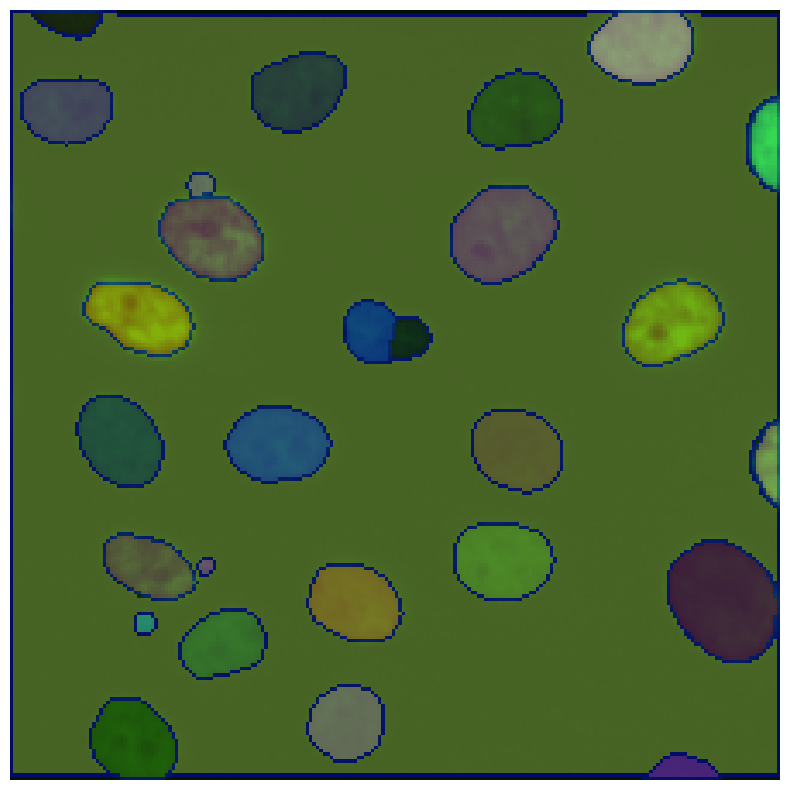

In [ ]:
img = Image.open("/content/mnMask_v2/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_05h57m-15.png")
img = np.array(img.convert("RGB"))
masks = mask_generator.generate(img)
plt.figure(figsize=(10, 10))
plt.imshow(img)
show_anns(masks)
plt.axis('off')
plt.show()

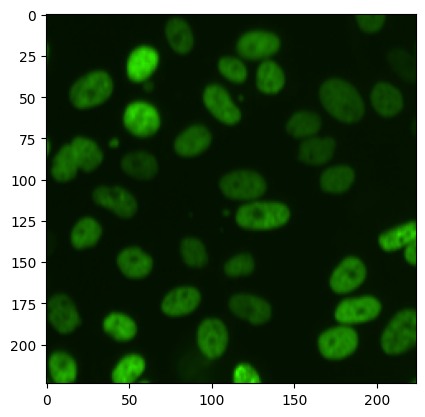

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "/content/example.png"
point = [0,0]
# output_image = app.predict_display(image_path,point,print_labels=False)
image = Image.open(image_path)
# plt.imshow(image)
("mn.png")
plt.imshow(image)
plt.show()

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

img_path = "/content/2.png"
image = Image.open(img_path)
image = np.array(image.convert("RGB"))
image.shape
img = image[30:330,300:550]
plt.imshow(img)
plt.imsave("g2.png",img)

## test output

In [ ]:
import os
import argparse
import numpy as np
import json
from PIL import Image
import time

import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from mn_segmentation.lib.Application import Application
from mn_segmentation.lib.image_encode import mask2rle
# from mn_segmentation.lib.assign_parent import add_parents

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

# get mn_info
def get_mn_info(image_path, model, conf=0.7):
  return model.predict_image_info(image_path, conf=conf)

# get nuc_info
def get_nuc_info(image_path, model):
  img = Image.open(image_path)
  img = np.array(img.convert("RGB"))
  masks = model.generate(img)

  output = {"coord":[], "area":[], "bbox":[], "score":[], "mask":[]}
  output["height"] = img.shape[0]
  output["width"] = img.shape[1]

  cur = 0
  for i in range(len(masks)):
    if masks[i]["area"] > cur:
      bg = i
      cur = masks[i]["area"]

  for i,ann in enumerate(masks):
    if ann['area'] > 100 and i != bg:
      x,y,w,h = ann['bbox']
      output["coord"].append([x+w//2, y+h//2])
      output["area"].append(ann['area'])
      output["bbox"].append(ann['bbox'])
      output["score"].append(ann['stability_score'])
      output["mask"].append(mask2rle(ann['segmentation'].astype(int)))
  return output

# get image_info
def get_image_info(image_path, nuc_model, mn_model, mode="ALL", conf=0.7):
    image_name = image_path.split("/")[-1]

    nuc_info = get_nuc_info(image_path, nuc_model) if mode=="ALL" or mode=="NUC" else None
    mn_info = get_mn_info(image_path, mn_model, conf=conf) if mode=="ALL" or mode=="MN" else None

    return {
        "image": image_name,
        "nuclei": nuc_info,
        "micronuclei": mn_info
    }

def run(folder, dst, parent, conf, mode="ALL"):
    # predict all the images and write into data frame

    # mn seg model
    app = Application("./MicroNuclei_Detection/checkpoints/maskrcnn-resnet50fpn.pt")

    # nuc seg model
    checkpoint = "./sam2/checkpoints/sam2.1_hiera_large.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

    sam2 = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)
    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2,
        points_per_side=64,
        points_per_batch=128,
        pred_iou_thresh=0.7,
        stability_score_thresh=0.92,
        stability_score_offset=0.7,
        min_mask_region_area=25
    )

    pred = []
    image_paths = os.listdir(folder)
    print(f"The number of images in source folder is {len(image_paths)}")

    cnt = 0
    t = 0

    for image_name in image_paths:
        if image_name[:2] == "._": continue

        image_path = os.path.join(folder,image_name)

        start = time.time()
        info = get_image_info(image_path, mask_generator, app, mode=mode, conf=conf)
        t += time.time() - start
        cnt += 1

        pred.append(info)

    print(f"Average processing time per image is {t/cnt}")

    # assign mn parent
    if mode=="ALL":
        add_parents(pred, parent)

    with open(dst, "w") as outfile:
        json.dump(pred, outfile)


PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True
using device: cuda


# new output with rle mask in json

In [ ]:
image_path= "/content/mnMask_v2/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_05h57m-15.png"
info = get_image_info(image_path, mask_generator, app, mode="ALL", conf=0.7)
with open("test.json", "w") as outfile:
  json.dump(info, outfile)
# info["micronuclei"]["bbox"][0]
from mn_segmentation.lib.assign_parent import add_parents
add_parents([info],"edge")

RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes


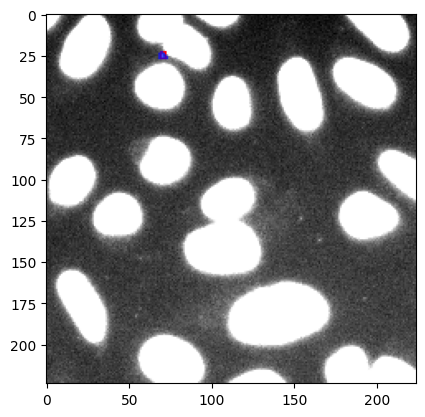

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


# img = Image.open("/content/b.tif")
# img_arr = np.array(img.convert("L"))

# img_arr -= np.min(img_arr)
# img = Image.fromarray(img_arr.astype(np.uint8))
# img.convert("RGB").save("/content/rgb.tif")
# # img = np.array(img.convert("RGB"))
# plt.imshow(img)
# print(img_arr)
# print(np.unique(np.array(img)))

point = [0,0]
image_path = "/content/rgb.tif"
output_image = app.predict_display(image_path,point,conf=0,print_labels=False)
image = output_image.permute(1,2,0)
# # plt.imshow(image)
# # plt.imsave("mn.png", image)
plt.imshow(image)

In [ ]:



from PIL import Image
import numpy as np
from multiprocessing import Pool
import os

image_path = "folder/to/images"
dest_path = "folder/to/save"

def process_image(file_name):
  img = Image.open(os.path.join(image_path, file_name))
  img_arr = np.array(img.convert("L"))

  img_arr -= np.min(img_arr)
  img = Image.fromarray(img_arr.astype(np.uint8))

  img.convert("RGB").save(os.path.join(dest_path, file_name))

def process_folder():
  with Pool(processes=4) as pool:
    pool.imap(process_image, os.listdir(image_path))

if __name__ == "__main__":
  process_folder()

In [ ]:
len(app.predict_image_info("/content/rgb.tif")['area'])

5

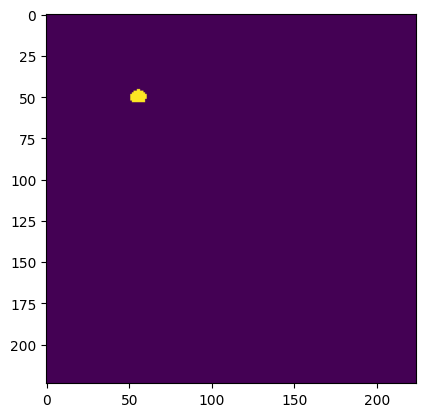

In [ ]:
plt.imshow(app.predict_image_mask(image_path)==1)

RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
[18, 15, 15]


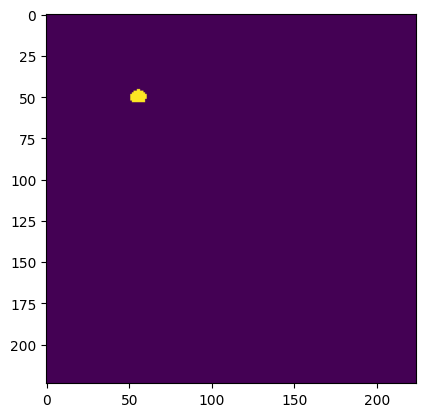

In [ ]:
from mn_segmentation.lib.image_encode import rle_to_mask, mask2rle
plt.imshow(rle_to_mask(info["micronuclei"]["mask"][0],224,224))
print(info["micronuclei"]["parent"])

In [ ]:
img = Image.open(image_path)
img = np.array(img.convert("RGB"))
masks = mask_generator.generate(img)

48750
698
559
553
899
568
531
496
550
202
443
511
533
416
513
412
399
130
520
604
533
358
145
56
129
42
27
1049
577
135
910


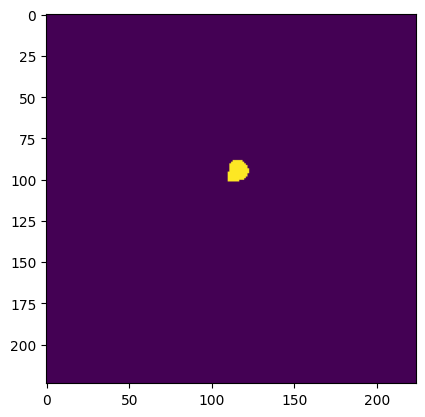

In [ ]:
plt.imshow(masks[-2]['segmentation'])
for mask in masks:
  print(mask['area'])

# new parent algorithm

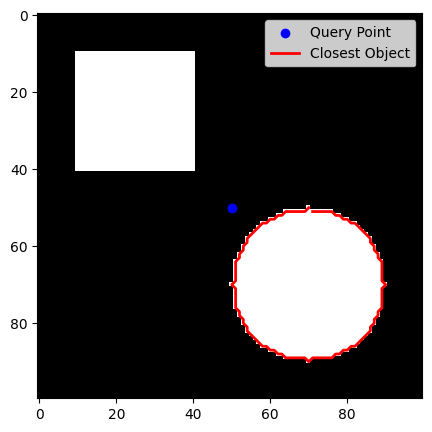

Distance to Closest Object: 8.48528137423857


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def extract_polygons(mask):
    """Extracts polygons from a binary mask using OpenCV findContours"""
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = [cnt.reshape(-1, 2) for cnt in contours]  # Convert contours to list of points
    return polygons

def point_to_segment_distance(px, py, x1, y1, x2, y2):
    """Compute the shortest distance from a point (px, py) to a line segment (x1, y1) -> (x2, y2)"""
    A = np.array([x1, y1])
    B = np.array([x2, y2])
    P = np.array([px, py])

    AB = B - A
    AP = P - A
    t = np.dot(AP, AB) / np.dot(AB, AB) if np.dot(AB, AB) > 0 else 0

    if t < 0:
        closest = A
    elif t > 1:
        closest = B
    else:
        closest = A + t * AB

    return np.linalg.norm(P - closest)

def closest_polygon_edge_distance(point, mask):
    """Find the closest polygon to a given point using contours from a binary mask"""
    px, py = point
    polygons = extract_polygons(mask)

    min_distance = float('inf')
    closest_polygon = None

    for polygon in polygons:
        for i in range(len(polygon)):
            x1, y1 = polygon[i]
            x2, y2 = polygon[(i+1) % len(polygon)]  # Loop back to first point
            dist = point_to_segment_distance(px, py, x1, y1, x2, y2)

            if dist < min_distance:
                min_distance = dist
                closest_polygon = polygon

    return closest_polygon, min_distance

# --- Example Usage ---
# Create a binary mask with some shapes
mask = np.zeros((100, 100), dtype=np.uint8)
cv2.rectangle(mask, (10, 10), (40, 40), 255, -1)  # Filled rectangle
cv2.circle(mask, (70, 70), 20, 255, -1)  # Filled circle

# Query point
query_point = (50, 50)

# Find closest object
closest_poly, distance = closest_polygon_edge_distance(query_point, mask)

# --- Visualization ---
plt.figure(figsize=(5, 5))
plt.imshow(mask, cmap='gray')
plt.scatter(*query_point, color='blue', label='Query Point')

# Draw the closest contour
if closest_poly is not None:
    closest_poly = np.array(closest_poly)
    plt.plot(closest_poly[:, 0], closest_poly[:, 1], 'r-', linewidth=2, label='Closest Object')

plt.legend()
plt.show()

print("Distance to Closest Object:", distance)


In [ ]:
import tifffile

# Load the TIFF file
file_path = "b.tif"  # Replace with your actual file path
file_path2 = "g.tif"  # Replace with your actual file path
with tifffile.TiffFile(file_path) as tif:
    # Print metadata
    print("TIFF Metadata:", tif.pages[0].tags)

    # Print a summary of the TIFF file
    # print(tif.info())

    # If there are image metadata
    if tif.pages[0].tags.get("ImageDescription"):
        print("Image Description:", tif.pages[0].tags["ImageDescription"].value)

    print("TIFF Metadata:", tif.pages[0].tags)

TIFF Metadata: TiffTag 256 ImageWidth @723850 SHORT @723858 = 696
TiffTag 257 ImageLength @723862 SHORT @723870 = 520
TiffTag 258 BitsPerSample @723874 SHORT @723882 = 16
TiffTag 259 Compression @723886 SHORT @723894 = NONE
TiffTag 262 PhotometricInterpretation @723898 SHORT @723906 = MINISBLACK
TiffTag 266 FillOrder @723910 SHORT @723918 = MSB2LSB
TiffTag 270 ImageDescription @723922 ASCII[405] @724114 = Experiment base name:
TiffTag 273 StripOffsets @723934 LONG @723942 = (8,)
TiffTag 274 Orientation @723946 SHORT @723954 = TOPLEFT
TiffTag 277 SamplesPerPixel @723958 SHORT @723966 = 1
TiffTag 278 RowsPerStrip @723970 SHORT @723978 = 520
TiffTag 279 StripByteCounts @723982 LONG @723990 = (723840,)
TiffTag 282 XResolution @723994 RATIONAL @724082 = (72, 1)
TiffTag 283 YResolution @724006 RATIONAL @724090 = (72, 1)
TiffTag 284 PlanarConfiguration @724018 SHORT @724026 = CONTIG
TiffTag 286 XPosition @724030 RATIONAL @724098 = (0, 1)
TiffTag 287 YPosition @724042 RATIONAL @724106 = (0, 1)

In [ ]:
import tifffile

# Load the TIFF file
file_path = "b.tif"  # Replace with your actual file path
file_path2 = "g.tif"  # Replace with your actual file path
with tifffile.TiffFile(file_path2) as tif:
    # Print metadata
    print("TIFF Metadata:", tif.pages[0].tags)

    # Print a summary of the TIFF file
    # print(tif.info())

    # If there are image metadata
    if tif.pages[0].tags.get("ImageDescription"):
        print("Image Description:", tif.pages[0].tags["ImageDescription"].value)

    print("TIFF Metadata:", tif.pages[0].tags)

TIFF Metadata: TiffTag 256 ImageWidth @4392970 SHORT @4392978 = 1408
TiffTag 257 ImageLength @4392982 SHORT @4392990 = 1040
TiffTag 258 BitsPerSample @4392994 SHORT[3] @4393246 = (8, 8, 8)
TiffTag 259 Compression @4393006 SHORT @4393014 = NONE
TiffTag 262 PhotometricInterpretation @4393018 SHORT @4393026 = RGB
TiffTag 266 FillOrder @4393030 SHORT @4393038 = MSB2LSB
TiffTag 273 StripOffsets @4393042 LONG[5] @4393272 = (8, 1013768, 2027528, 3041
TiffTag 274 Orientation @4393054 SHORT @4393062 = TOPLEFT
TiffTag 277 SamplesPerPixel @4393066 SHORT @4393074 = 3
TiffTag 278 RowsPerStrip @4393078 SHORT @4393086 = 240
TiffTag 279 StripByteCounts @4393090 LONG[5] @4393252 = (1013760, 1013760, 1013
TiffTag 282 XResolution @4393102 RATIONAL @4393214 = (96, 1)
TiffTag 283 YResolution @4393114 RATIONAL @4393222 = (96, 1)
TiffTag 284 PlanarConfiguration @4393126 SHORT @4393134 = CONTIG
TiffTag 286 XPosition @4393138 RATIONAL @4393230 = (0, 1)
TiffTag 287 YPosition @4393150 RATIONAL @4393238 = (0, 1)


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Open the image
file_path = "b.tif"  # Replace with your actual file path
image = Image.open(file_path)
# Get image mode (e.g., 'RGB', 'L' for grayscale)
print("Image Mode:", image.mode)

# Get the bit depth per channel
# bit_depth = image.mode, image.bits
# print("Bit Depth:", bit_depth)

# Convert image to NumPy array and check pixel values
# image = image.convert("RGB")
image_array = np.array(image)
print("Image Shape:", image_array.shape)
print("Pixel Sample (Top-left):", image_array[80, 550])  # Print a sample pixel value
np.min(image_array)

Image Mode: I;16
Image Shape: (520, 696)
Pixel Sample (Top-left): 170


65536

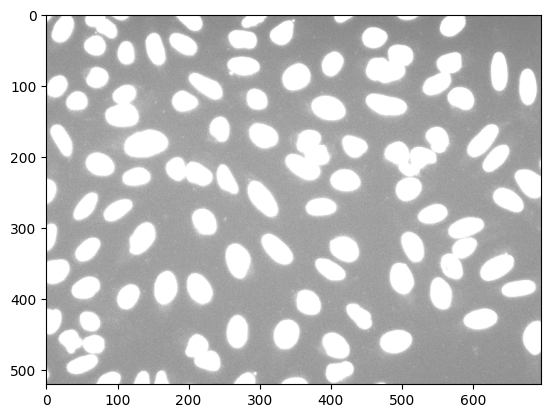

In [ ]:
# image = image.convert("RGB")
img = image
# img.point(lambda p: p*0.0039063096, mode='RGB')
img = img.convert('RGB')
plt.imshow(img)

In [ ]:
!python /content/test.py --src "a" --dst "b" --mode "c" --conf 1.79

Namespace(src='a', dst='b', mode='c', conf=1.79, out=None, parent=None) 1.0


In [ ]:
!cp /content/drive/MyDrive/PMCC/Analysis/Ulises_counts_all.zip -d /content
!unzip /content/Ulises_counts_all.zip -d /content

Archive:  /content/Ulises_counts_all.zip
   creating: /content/content/Ulises_counts/
   creating: /content/content/Ulises_counts/Day 6 tif/
  inflating: /content/content/Ulises_counts/Day 6 tif/VID3664_E6_3_2024y08m06d_11h44m.tif  
  inflating: /content/content/Ulises_counts/Day 6 tif/VID3664_B6_2_2024y08m06d_11h44m.tif  
  inflating: /content/content/Ulises_counts/Day 6 tif/VID3664_A5_2_2024y08m06d_11h44m.tif  
  inflating: /content/content/Ulises_counts/Day 6 tif/VID3664_A4_3_2024y08m06d_11h44m.tif  
  inflating: /content/content/Ulises_counts/Day 6 tif/VID3664_E6_4_2024y08m06d_11h44m.tif  
  inflating: /content/content/Ulises_counts/Day 6 tif/VID3664_B5_4_2024y08m06d_11h44m.tif  
  inflating: /content/content/Ulises_counts/Day 6 tif/VID3664_A6_4_2024y08m06d_11h44m.tif  
  inflating: /content/content/Ulises_counts/Day 6 tif/VID3664_C5_1_2024y08m06d_11h44m.tif  
  inflating: /content/content/Ulises_counts/Day 6 tif/VID3664_E4_3_2024y08m06d_11h44m.tif  
  inflating: /content/content/U

In [ ]:
!python ./mn_segmentation/exps/apop_study.py

Traceback (most recent call last):
  File "/content/MicroNuclei_Detection/./mn_segmentation/exps/apop_study.py", line 27, in <module>
    print(compare())
          ^^^^^^^^^
  File "/content/MicroNuclei_Detection/./mn_segmentation/exps/apop_study.py", line 21, in compare
    cnt_without_apop_resolve = app.predict_image_count(os.path.join(folder,image_path),False,0.7,True)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/MicroNuclei_Detection/mn_segmentation/lib/Application.py", line 191, in predict_image_count
    pred = self._predict(image)
           ^^^^^^^^^^^^^^^^^^^^
  File "/content/MicroNuclei_Detection/mn_segmentation/lib/Application.py", line 130, in _predict
    predictions = self.model([x, ])
                  ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^

In [ ]:
import os
from mn_segmentation.lib.Application import Application
from tqdm import tqdm

def compare():
    app = Application()

    pred = []

    folders = ["/content/Ulises_counts/Day 3 count", "/content/Ulises_counts/Day 6 count"]
    for i in range(2):
        folder = folders[i]
        image_paths = sorted(os.listdir(folder))

        for image_path in tqdm(image_paths):
            if image_path[:2] == "._": continue
            cnt_with_apop_resolve = app.predict_image_count(os.path.join(folder,image_path),True,0.7,True)
            cnt_without_apop_resolve = app.predict_image_count(os.path.join(folder,image_path),False,0.7,True)
            if cnt_with_apop_resolve != cnt_without_apop_resolve:
                pred.append(os.path.join(folder,image_path))
    return pred


print(compare())

100%|██████████| 60/60 [02:58<00:00,  2.97s/it]

[]
